# Forecasting with Python

---

**Techniques Covered:**
- Time Series Analysis
- ARIMA Modeling
- Exponential Smoothing
- Seasonal Decomposition
- Prophet
- LSTM for Time Series

---

## 1. Import Required Libraries

In [124]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Auto ARIMA
from pmdarima import auto_arima, arima

# Prophet
from prophet import Prophet

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Prepare Data

In [125]:
# Load hotel reservation data
df = pd.read_parquet('../data/processed/combined_daily_records.parquet')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (409257, 36)

First few rows:


,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,hotel_id,arrival_date,length_of_stay,departure_date,stay_date
0,0,7,2015,July,27,1,0,1,1,0.0,...,75.00,0,0,Check-Out,2015-07-02,H1,2015-07-01,1,2015-07-02,2015-07-01
1,0,37,2015,July,27,1,0,4,2,0.0,...,94.71,0,0,Check-Out,2015-07-05,H1,2015-07-01,4,2015-07-05,2015-07-01
2,0,118,2015,July,27,1,4,10,2,0.0,...,80.00,1,1,Check-Out,2015-07-15,H1,2015-07-01,14,2015-07-15,2015-07-01
3,0,68,2015,July,27,1,0,4,2,0.0,...,97.00,0,3,Check-Out,2015-07-05,H1,2015-07-01,4,2015-07-05,2015-07-01
4,0,37,2015,July,27,1,0,4,2,0.0,...,97.50,0,0,Check-Out,2015-07-05,H1,2015-07-01,4,2015-07-05,2015-07-01


In [126]:
# Check data types and missing values
print("Data Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nColumn names:")
print(df.columns.tolist())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409257 entries, 0 to 409256
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   IsCanceled                   409257 non-null  int64         
 1   LeadTime                     409257 non-null  int64         
 2   ArrivalDateYear              409257 non-null  int64         
 3   ArrivalDateMonth             409257 non-null  object        
 4   ArrivalDateWeekNumber        409257 non-null  int64         
 5   ArrivalDateDayOfMonth        409257 non-null  int64         
 6   StaysInWeekendNights         409257 non-null  int64         
 7   StaysInWeekNights            409257 non-null  int64         
 8   Adults                       409257 non-null  int64         
 9   Children                     409245 non-null  float64       
 10  Babies                       409257 non-null  int64         
 11  Meal           

In [127]:
# Aggregate daily reservations (count of bookings per day)
ts_data = df.groupby('stay_date', as_index = False)['ADR'].mean()

print("Time series shape:", ts_data.shape)
print("\nDate range:", ts_data['stay_date'].min(), "to", ts_data['stay_date'].max())
ts_data.head(10)

Time series shape: (806, 2)

Date range: 2015-07-01 00:00:00 to 2017-09-13 00:00:00


,stay_date,ADR
0,2015-07-01,94.376083
1,2015-07-02,89.090388
2,2015-07-03,87.719385
3,2015-07-04,90.598558
4,2015-07-05,91.370000
5,2015-07-06,90.992143
6,2015-07-07,91.132766
7,2015-07-08,94.103453
8,2015-07-09,91.315714
9,2015-07-10,97.062013


In [128]:
ts_data = ts_data.set_index('stay_date').sort_index()
ts_data = ts_data.resample('D').mean().round(2)
ts_data

,ADR
stay_date,
2015-07-01,94.38
2015-07-02,89.09
2015-07-03,87.72
2015-07-04,90.60
2015-07-05,91.37
...,...
2017-09-09,151.81
2017-09-10,157.03
2017-09-11,121.81


## 3. Exploratory Data Analysis

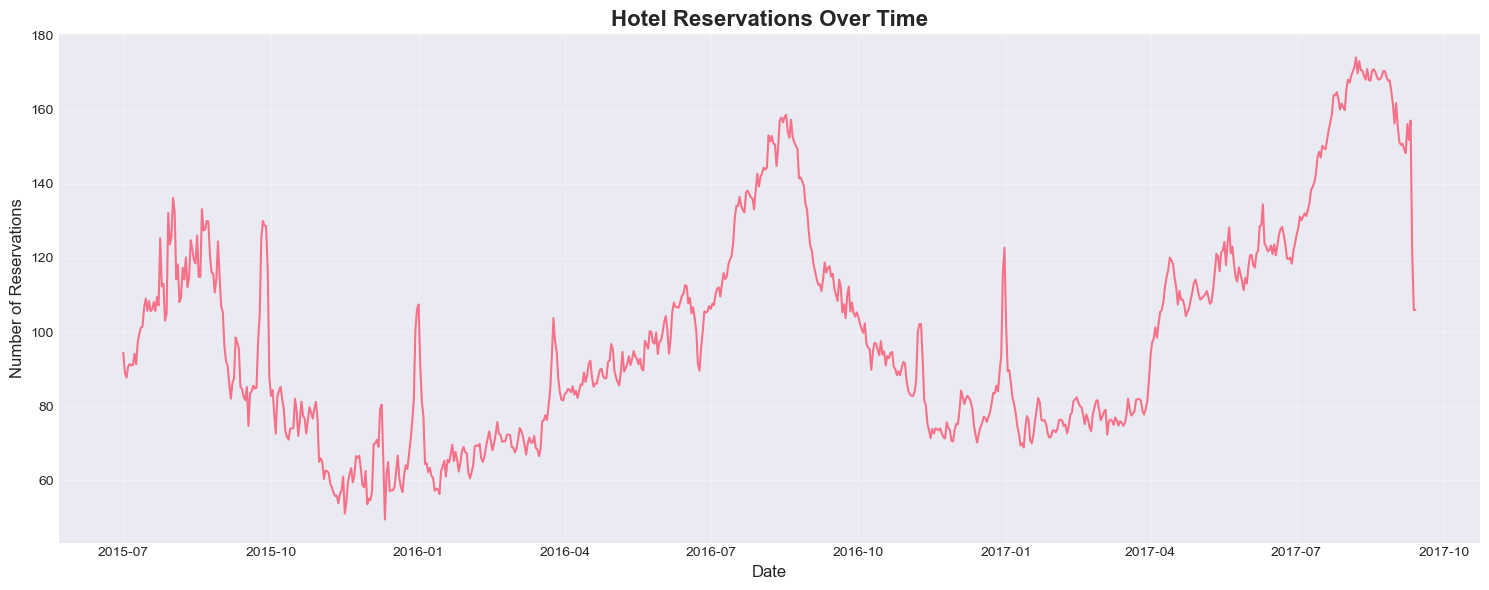


Basic Statistics:
              ADR
count  806.000000
mean    99.250596
std     29.030907
min     49.450000
25%     75.992500
50%     93.220000
75%    116.717500
max    174.050000


In [129]:
# Plot the time series
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(ts_data.index, ts_data, linewidth=1.5) 
ax.set_title('Hotel Reservations Over Time', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Reservations', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Basic statistics
print("\nBasic Statistics:")
print(ts_data.describe())

In [130]:
# Check for missing dates and fill gaps
date_range = pd.date_range(start=ts_data.index.min(), end=ts_data.index.max(), freq='D')
ts_data = ts_data.reindex(date_range, fill_value=0)
ts_data.index.name = 'date'

print(f"Total days in range: {len(date_range)}")
print(f"Days with data: {(ts_data > 0).sum()}")
print(f"Days filled with 0: {(ts_data == 0).sum()}")

Total days in range: 806
Days with data: ADR    806
dtype: int64
Days filled with 0: ADR    0
dtype: int64


## 4. Seasonal Decomposition

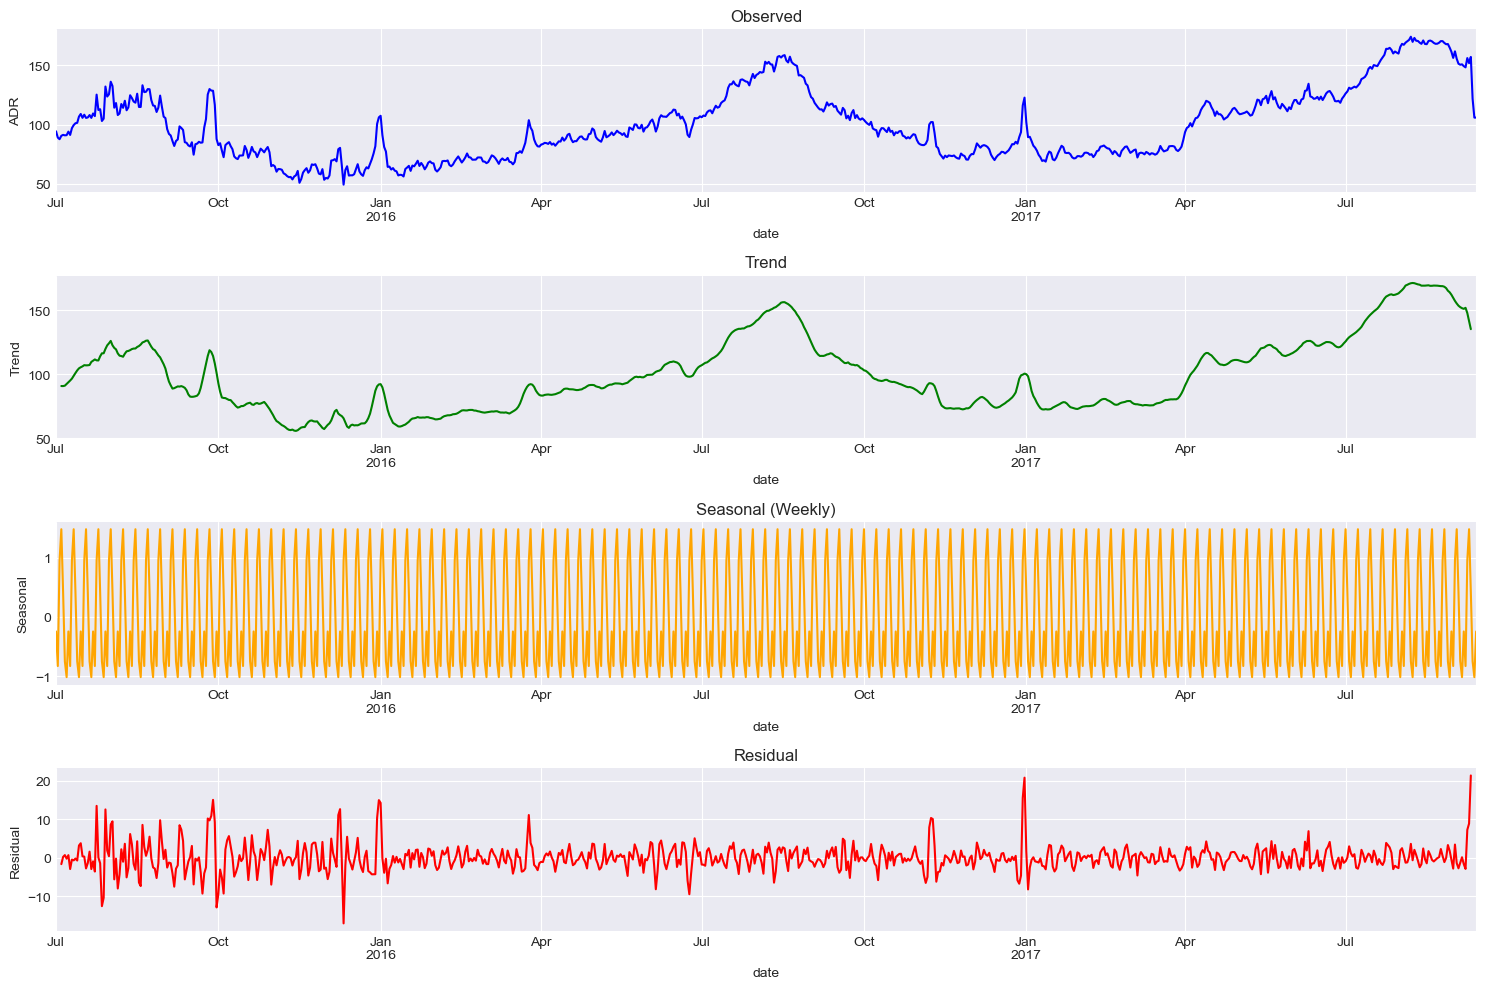

In [131]:
# Perform seasonal decomposition
# Using weekly seasonality (period=7) for daily data
decomposition = seasonal_decompose(ts_data, model='additive', period=7)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 10))

decomposition.observed.plot(ax=axes[0], title='Observed', color='blue')
axes[0].set_ylabel('ADR')

decomposition.trend.plot(ax=axes[1], title='Trend', color='green')
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], title='Seasonal (Weekly)', color='orange')
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], title='Residual', color='red')
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

## 5. Stationarity Testing

In [132]:
# Augmented Dickey-Fuller test for stationarity
def adf_test(series, title=''):
    """
    Perform Augmented Dickey-Fuller test
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("\n=> Strong evidence against null hypothesis")
        print("=> Reject null hypothesis - Data is stationary")
    else:
        print("\n=> Weak evidence against null hypothesis")
        print("=> Fail to reject null hypothesis - Data is non-stationary")
    print('-' * 60)

# Test original series
adf_test(ts_data, 'Original Series')

Augmented Dickey-Fuller Test: Original Series
ADF Statistic: -1.9496
p-value: 0.3091
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569

=> Weak evidence against null hypothesis
=> Fail to reject null hypothesis - Data is non-stationary
------------------------------------------------------------


In [133]:
# If non-stationary, apply differencing
ts_data['adr_diff'] = ts_data.diff()

# Test differenced series
adf_test(ts_data['adr_diff'], 'First Difference')

Augmented Dickey-Fuller Test: First Difference
ADF Statistic: -7.3640
p-value: 0.0000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569

=> Strong evidence against null hypothesis
=> Reject null hypothesis - Data is stationary
------------------------------------------------------------


## 6. ACF and PACF Analysis

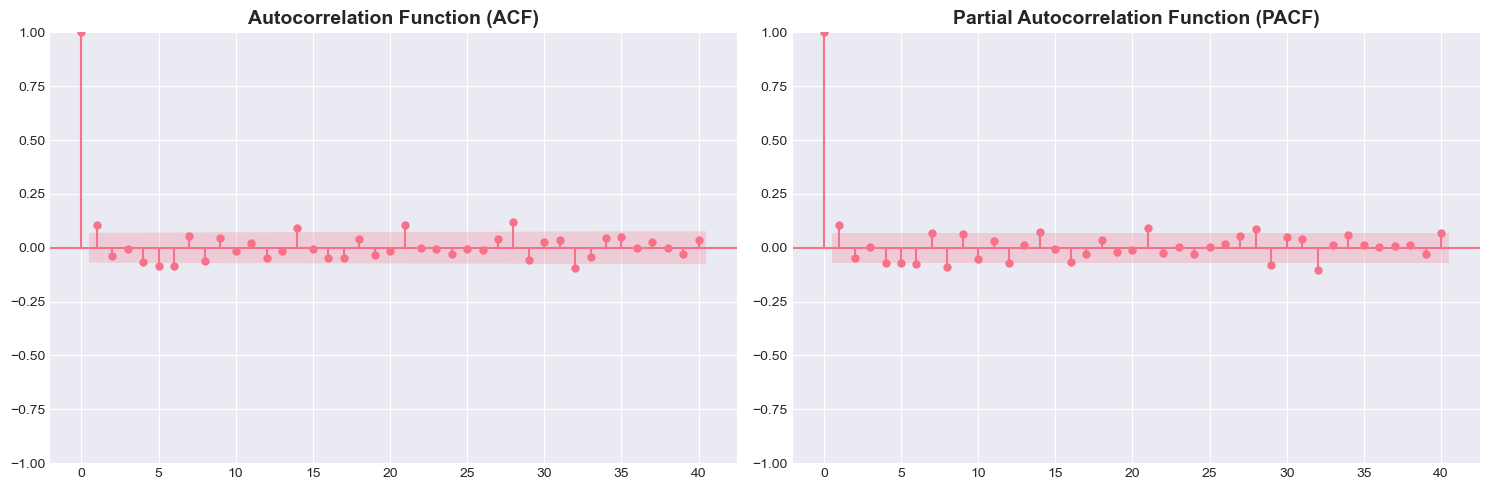

In [134]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF
plot_acf(ts_data['adr_diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')

# PACF
plot_pacf(ts_data['adr_diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Preprocessing for Outliers

Detected 0 outliers (0.00%)
Range: [14.91, 177.81]


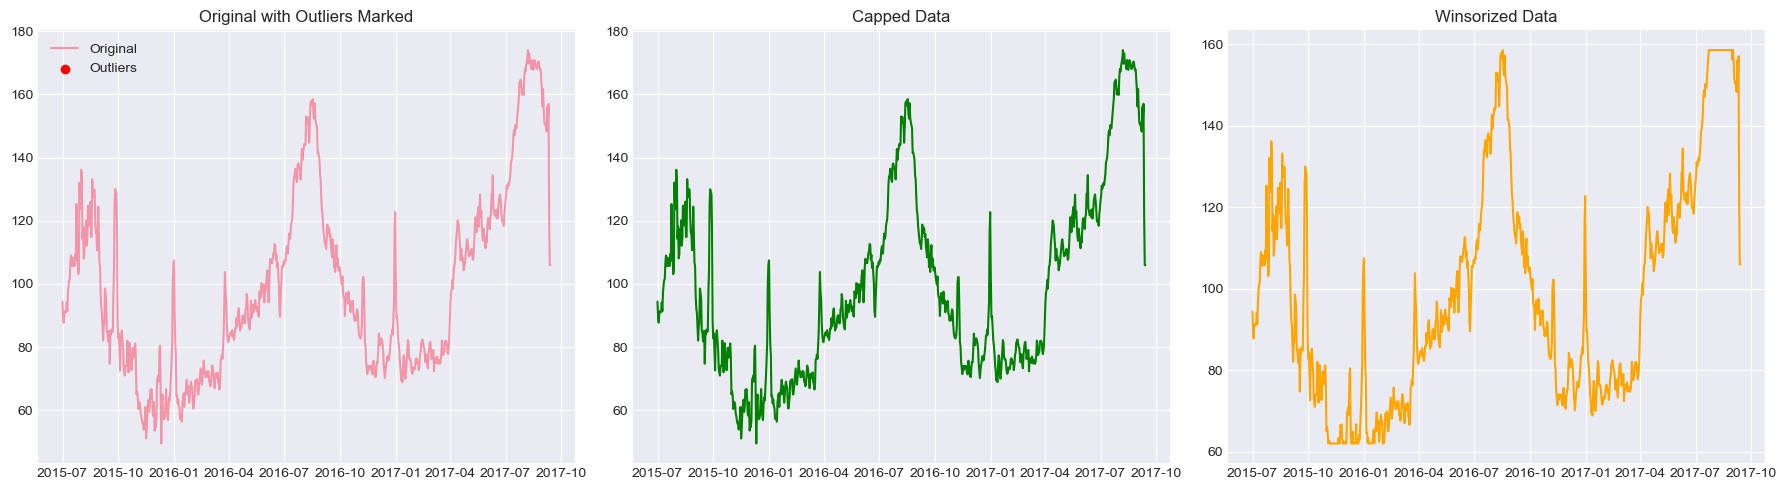

In [135]:
from scipy import stats

# Detect outliers using IQR method
def detect_outliers_iqr(data, multiplier=1.5):
    """Detect outliers using Interquartile Range method"""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers, lower_bound, upper_bound

# Apply to your data
outliers, lower, upper = detect_outliers_iqr(ts_data['ADR'])
print(f"Detected {outliers.sum()} outliers ({outliers.sum()/len(ts_data)*100:.2f}%)")
print(f"Range: [{lower:.2f}, {upper:.2f}]")

# Treatment options:
# Option 1: Cap outliers
ts_data['ADR_capped'] = ts_data['ADR'].clip(lower=lower, upper=upper)

# Option 2: Winsorize (replace with percentile values)
from scipy.stats.mstats import winsorize
ts_data['ADR_winsorized'] = winsorize(ts_data['ADR'], limits=[0.05, 0.05])

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(ts_data.index, ts_data['ADR'], label='Original', alpha=0.7)
axes[0].scatter(ts_data.index[outliers], ts_data.loc[outliers, 'ADR'], 
                color='red', label='Outliers', zorder=5)
axes[0].set_title('Original with Outliers Marked')
axes[0].legend()

axes[1].plot(ts_data.index, ts_data['ADR_capped'], color='green')
axes[1].set_title('Capped Data')

axes[2].plot(ts_data.index, ts_data['ADR_winsorized'], color='orange')
axes[2].set_title('Winsorized Data')

plt.tight_layout()
plt.show()

## 6.5. Preprocessing: Box-Cox Transformation

In [136]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Box-Cox transformation helps stabilize variance and make data more normal
# It's particularly useful when data has heteroscedasticity (varying variance)

# Drop the temporary diff column if it exists
if 'adr_diff' in ts_data.columns:
    ts_data = ts_data.drop(columns=['adr_diff'])

# Apply Box-Cox transformation
# Note: Box-Cox requires positive values, so we ensure all values are > 0
ts_data_values = ts_data['ADR'].values

# Check if data needs shifting (if there are zeros or negative values)
min_val = ts_data_values.min()
if min_val <= 0:
    shift_value = abs(min_val) + 1
    ts_data_values_shifted = ts_data_values + shift_value
    print(f"Data shifted by {shift_value} to ensure positive values")
else:
    ts_data_values_shifted = ts_data_values
    shift_value = 0

# Perform Box-Cox transformation
ts_data_boxcox, lambda_param = boxcox(ts_data_values_shifted)

print(f"Box-Cox lambda parameter: {lambda_param:.4f}")
print(f"Interpretation:")
if abs(lambda_param - 1) < 0.1:
    print("  λ ≈ 1: No transformation needed")
elif abs(lambda_param - 0.5) < 0.1:
    print("  λ ≈ 0.5: Square root transformation")
elif abs(lambda_param) < 0.1:
    print("  λ ≈ 0: Log transformation")
elif abs(lambda_param + 1) < 0.1:
    print("  λ ≈ -1: Inverse transformation")
else:
    print(f"  λ = {lambda_param:.4f}: Custom power transformation")

# Store transformed data
ts_data['ADR_boxcox'] = ts_data_boxcox

# Store parameters for inverse transformation later
boxcox_params = {
    'lambda': lambda_param,
    'shift': shift_value
}

print(f"\nOriginal data range: [{ts_data['ADR'].min():.2f}, {ts_data['ADR'].max():.2f}]")
print(f"Transformed data range: [{ts_data['ADR_boxcox'].min():.2f}, {ts_data['ADR_boxcox'].max():.2f}]")

Box-Cox lambda parameter: -0.3513
Interpretation:
  λ = -0.3513: Custom power transformation

Original data range: [49.45, 174.05]
Transformed data range: [2.12, 2.38]


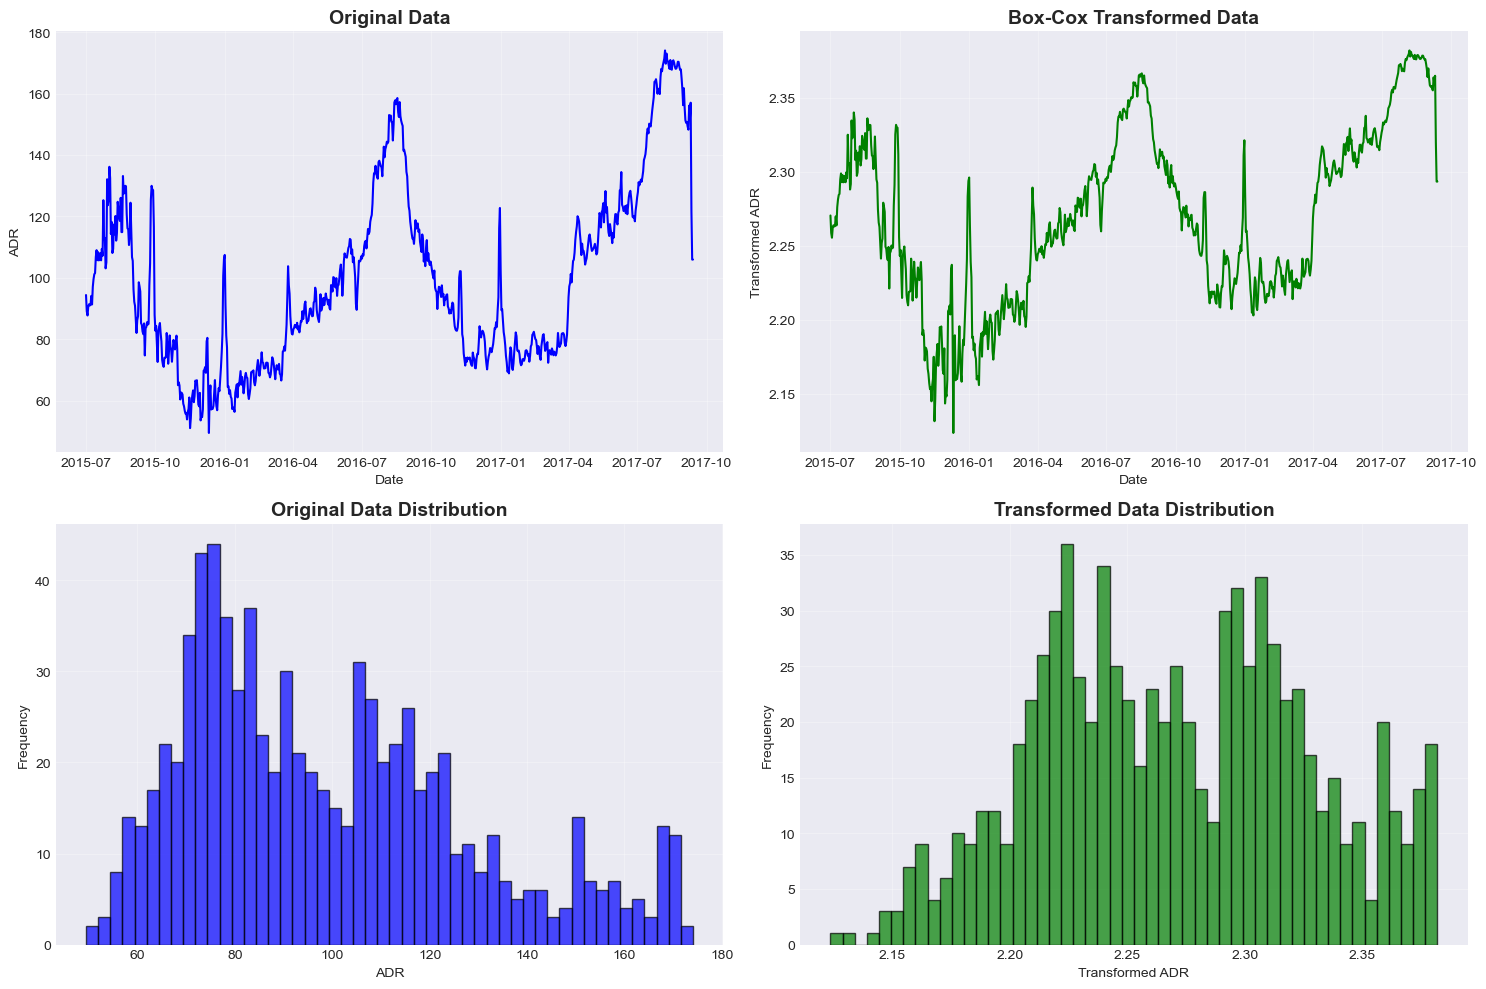

Box-Cox transformation helps:
✓ Stabilize variance across time
✓ Make the distribution more normal
✓ Improve model performance and residual behavior


In [137]:
# Visualize the effect of Box-Cox transformation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original data time series
axes[0, 0].plot(ts_data.index, ts_data['ADR'], color='blue', linewidth=1.5)
axes[0, 0].set_title('Original Data', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('ADR')
axes[0, 0].grid(True, alpha=0.3)

# Transformed data time series
axes[0, 1].plot(ts_data.index, ts_data['ADR_boxcox'], color='green', linewidth=1.5)
axes[0, 1].set_title('Box-Cox Transformed Data', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Transformed ADR')
axes[0, 1].grid(True, alpha=0.3)

# Original data distribution
axes[1, 0].hist(ts_data['ADR'], bins=50, color='blue', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Original Data Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('ADR')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Transformed data distribution
axes[1, 1].hist(ts_data['ADR_boxcox'], bins=50, color='green', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Transformed Data Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Transformed ADR')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Box-Cox transformation helps:")
print("✓ Stabilize variance across time")
print("✓ Make the distribution more normal")
print("✓ Improve model performance and residual behavior")

## 6.6. Preprocessing: Fourier Features for Seasonality

In [138]:
# Fourier features capture seasonal patterns using sine and cosine functions
# They're especially useful for modeling multiple seasonal patterns simultaneously

def create_fourier_features(index, period, order):
    """
    Create Fourier features for a given period and order.
    
    Parameters:
    -----------
    index : pd.DatetimeIndex
        Time index for the data
    period : int
        Seasonal period (e.g., 7 for weekly, 365.25 for yearly)
    order : int
        Number of Fourier pairs to create (higher = more flexible but more complex)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with sine and cosine features
    """
    # Create time index as integers (days from start)
    t = np.arange(len(index))
    
    features = pd.DataFrame(index=index)
    
    for i in range(1, order + 1):
        features[f'sin_{period}_{i}'] = np.sin(2 * np.pi * i * t / period)
        features[f'cos_{period}_{i}'] = np.cos(2 * np.pi * i * t / period)
    
    return features

# Create Fourier features for weekly and yearly seasonality
weekly_fourier = create_fourier_features(ts_data.index, period=7, order=3)  # 3 pairs for weekly
yearly_fourier = create_fourier_features(ts_data.index, period=365.25, order=5)  # 5 pairs for yearly

# Combine features
fourier_features = pd.concat([weekly_fourier, yearly_fourier], axis=1)

print("Fourier Features Created:")
print(f"  Weekly seasonality: {weekly_fourier.shape[1]} features (period=7, order=3)")
print(f"  Yearly seasonality: {yearly_fourier.shape[1]} features (period=365.25, order=5)")
print(f"  Total features: {fourier_features.shape[1]}")
print(f"\nFeature columns:")
print(fourier_features.columns.tolist())

Fourier Features Created:
  Weekly seasonality: 6 features (period=7, order=3)
  Yearly seasonality: 10 features (period=365.25, order=5)
  Total features: 16

Feature columns:
['sin_7_1', 'cos_7_1', 'sin_7_2', 'cos_7_2', 'sin_7_3', 'cos_7_3', 'sin_365.25_1', 'cos_365.25_1', 'sin_365.25_2', 'cos_365.25_2', 'sin_365.25_3', 'cos_365.25_3', 'sin_365.25_4', 'cos_365.25_4', 'sin_365.25_5', 'cos_365.25_5']


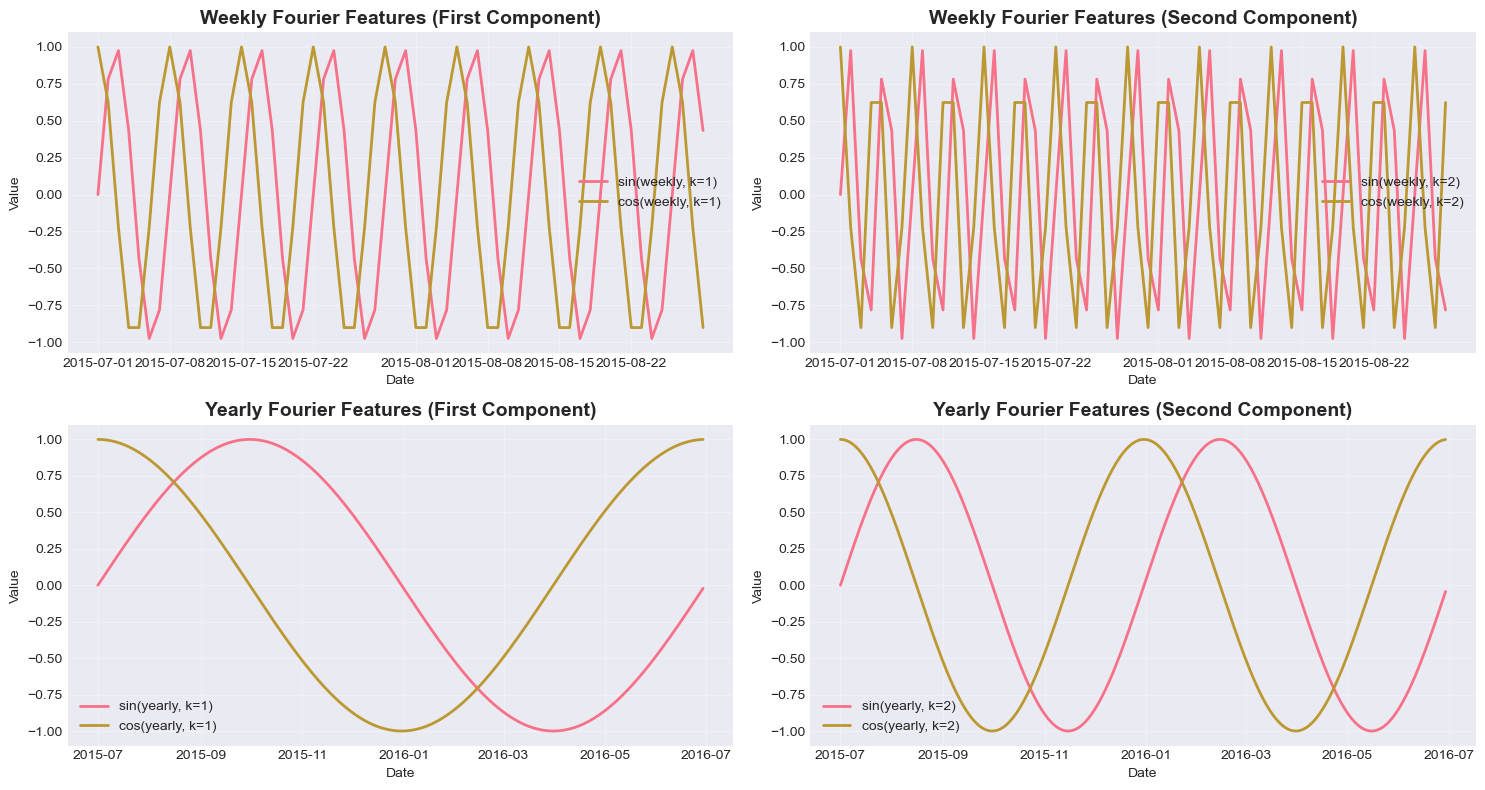


Fourier features advantages:
✓ Capture complex seasonal patterns
✓ Can model multiple seasonalities simultaneously
✓ Smooth representation of periodic behavior
✓ Can be used as exogenous variables in ARIMAX/SARIMAX models


In [139]:
# Visualize some of the Fourier features
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Weekly patterns - first two components
axes[0, 0].plot(ts_data.index[:60], weekly_fourier['sin_7_1'][:60], label='sin(weekly, k=1)', linewidth=2)
axes[0, 0].plot(ts_data.index[:60], weekly_fourier['cos_7_1'][:60], label='cos(weekly, k=1)', linewidth=2)
axes[0, 0].set_title('Weekly Fourier Features (First Component)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(ts_data.index[:60], weekly_fourier['sin_7_2'][:60], label='sin(weekly, k=2)', linewidth=2)
axes[0, 1].plot(ts_data.index[:60], weekly_fourier['cos_7_2'][:60], label='cos(weekly, k=2)', linewidth=2)
axes[0, 1].set_title('Weekly Fourier Features (Second Component)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Yearly patterns - first two components
axes[1, 0].plot(ts_data.index[:365], yearly_fourier['sin_365.25_1'][:365], label='sin(yearly, k=1)', linewidth=2)
axes[1, 0].plot(ts_data.index[:365], yearly_fourier['cos_365.25_1'][:365], label='cos(yearly, k=1)', linewidth=2)
axes[1, 0].set_title('Yearly Fourier Features (First Component)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(ts_data.index[:365], yearly_fourier['sin_365.25_2'][:365], label='sin(yearly, k=2)', linewidth=2)
axes[1, 1].plot(ts_data.index[:365], yearly_fourier['cos_365.25_2'][:365], label='cos(yearly, k=2)', linewidth=2)
axes[1, 1].set_title('Yearly Fourier Features (Second Component)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFourier features advantages:")
print("✓ Capture complex seasonal patterns")
print("✓ Can model multiple seasonalities simultaneously")
print("✓ Smooth representation of periodic behavior")
print("✓ Can be used as exogenous variables in ARIMAX/SARIMAX models")

In [140]:
# Helper function for inverse Box-Cox transformation
def inverse_boxcox_transform(data, lambda_param, shift_value):
    """
    Inverse Box-Cox transformation to get back to original scale.
    
    Parameters:
    -----------
    data : array-like
        Box-Cox transformed data
    lambda_param : float
        Lambda parameter from Box-Cox transformation
    shift_value : float
        Shift applied before transformation
    
    Returns:
    --------
    array-like
        Data in original scale
    """
    # Inverse Box-Cox
    original_scale = inv_boxcox(data, lambda_param)
    
    # Remove the shift if it was applied
    if shift_value > 0:
        original_scale = original_scale - shift_value
    
    return original_scale

print("Inverse transformation function created!")
print("This will be used to convert predictions back to original scale.")

Inverse transformation function created!
This will be used to convert predictions back to original scale.


In [141]:
# ts_data = ts_data.drop(columns=['adr_diff'])

## 7. Train-Test Split

TRAIN-TEST SPLIT SUMMARY
Training set size: 685 days (85.0%)
Testing set size: 121 days (15.0%)

Train date range: 2015-07-01 00:00:00 to 2017-05-15 00:00:00
Test date range: 2017-05-16 00:00:00 to 2017-09-13 00:00:00

Data available for modeling:
  ✓ Original data: train ((685,)), test ((121,))
  ✓ Box-Cox transformed: train ((685,)), test ((121,))
  ✓ Fourier features: train ((685, 16)), test ((121, 16))


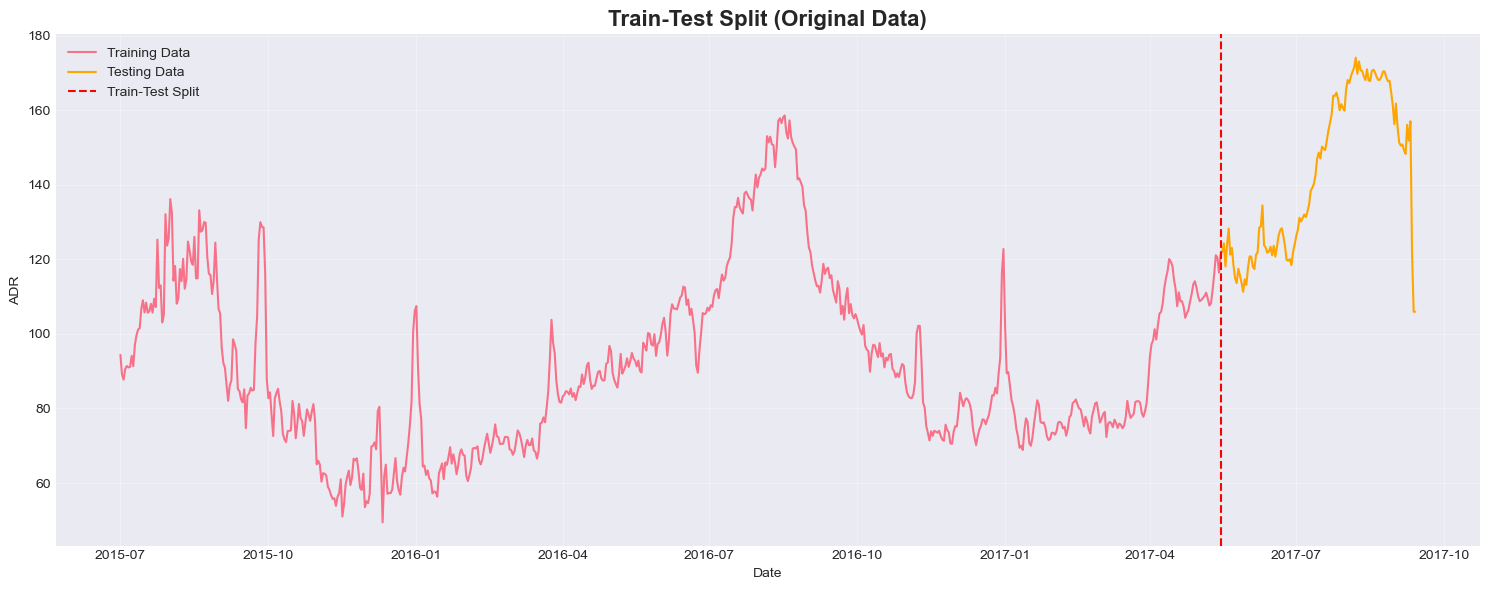

In [142]:
# Split data into training and testing sets (80-20 split)
train_size = int(len(ts_data) * 0.85)

# Split ORIGINAL data (for models that don't use transformations)
train = ts_data['ADR'][:train_size]
test = ts_data['ADR'][train_size:]

# Split TRANSFORMED data (for models using Box-Cox)
train_transformed = ts_data['ADR_boxcox'][:train_size]
test_transformed = ts_data['ADR_boxcox'][train_size:]

# Split FOURIER FEATURES (for models using exogenous variables)
fourier_train = fourier_features[:train_size]
fourier_test = fourier_features[train_size:]

print("="*70)
print("TRAIN-TEST SPLIT SUMMARY")
print("="*70)
print(f"Training set size: {len(train)} days ({(len(train)/len(ts_data)*100):.1f}%)")
print(f"Testing set size: {len(test)} days ({(len(test)/len(ts_data)*100):.1f}%)")
print(f"\nTrain date range: {train.index.min()} to {train.index.max()}")
print(f"Test date range: {test.index.min()} to {test.index.max()}")

print(f"\nData available for modeling:")
print(f"  ✓ Original data: train ({train.shape}), test ({test.shape})")
print(f"  ✓ Box-Cox transformed: train ({train_transformed.shape}), test ({test_transformed.shape})")
print(f"  ✓ Fourier features: train ({fourier_train.shape}), test ({fourier_test.shape})")
print("="*70)

# Visualize the split
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Training Data', linewidth=1.5)
plt.plot(test.index, test, label='Testing Data', linewidth=1.5, color='orange')
plt.axvline(x=train.index[-1], color='red', linestyle='--', label='Train-Test Split')
plt.title('Train-Test Split (Original Data)', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

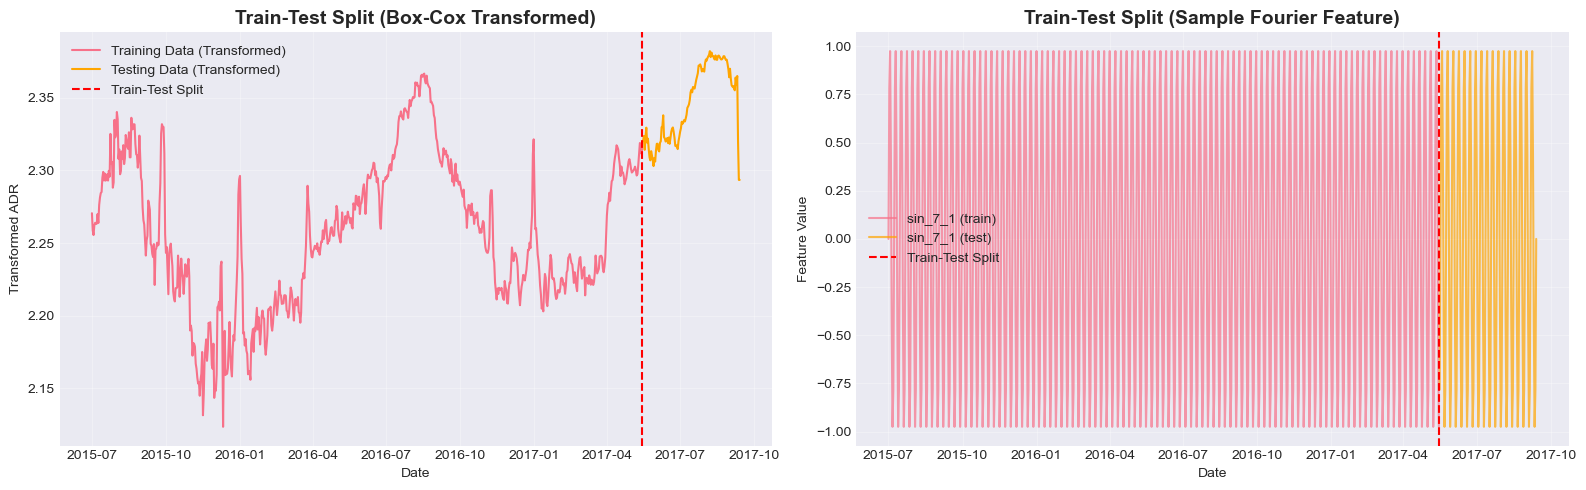


Key Points:
• Transformations were applied to the FULL dataset before splitting
• This ensures no data leakage (no information from test set in training)
• Both train and test sets use the same transformation parameters
• Box-Cox λ parameter (-0.3513) was computed from full data


In [143]:
# Visualize the transformed data split
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Box-Cox transformed data
axes[0].plot(train_transformed.index, train_transformed, label='Training Data (Transformed)', linewidth=1.5)
axes[0].plot(test_transformed.index, test_transformed, label='Testing Data (Transformed)', linewidth=1.5, color='orange')
axes[0].axvline(x=train.index[-1], color='red', linestyle='--', label='Train-Test Split')
axes[0].set_title('Train-Test Split (Box-Cox Transformed)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Transformed ADR')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sample Fourier features
axes[1].plot(fourier_train.index, fourier_train['sin_7_1'], label='sin_7_1 (train)', linewidth=1.5, alpha=0.7)
axes[1].plot(fourier_test.index, fourier_test['sin_7_1'], label='sin_7_1 (test)', linewidth=1.5, alpha=0.7, color='orange')
axes[1].axvline(x=train.index[-1], color='red', linestyle='--', label='Train-Test Split')
axes[1].set_title('Train-Test Split (Sample Fourier Feature)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Feature Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Points:")
print("• Transformations were applied to the FULL dataset before splitting")
print("• This ensures no data leakage (no information from test set in training)")
print("• Both train and test sets use the same transformation parameters")
print(f"• Box-Cox λ parameter ({boxcox_params['lambda']:.4f}) was computed from full data")

## 8. Model 1: ARIMA (Manual)

In [144]:
# Fit ARIMA model with manually selected parameters
# Using ARIMA(p, d, q) - based on ACF/PACF analysis
# p = AR order, d = differencing order, q = MA order

# Example: ARIMA(1, 1, 1) with Box-Cox transformed data
print("Fitting ARIMA with Box-Cox transformation...")
arima_model = ARIMA(train_transformed, order=(1, 1, 1))
arima_fit = arima_model.fit()

print("\nARIMA Model Summary (Box-Cox Transformed):")
print(arima_fit.summary())

Fitting ARIMA with Box-Cox transformation...

ARIMA Model Summary (Box-Cox Transformed):
                               SARIMAX Results                                
Dep. Variable:             ADR_boxcox   No. Observations:                  685
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2138.405
Date:                Thu, 15 Jan 2026   AIC                          -4270.810
Time:                        17:01:23   BIC                          -4257.227
Sample:                    07-01-2015   HQIC                         -4265.554
                         - 05-15-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3484      0.171     -2.036      0.042      -0.684      -0.013
ma.L1          0.4512      0.171      2.64

In [145]:
d = arima.ndiffs(ts_data['ADR_boxcox'])
D = arima.nsdiffs(ts_data['ADR_boxcox'], m=7)


ARIMA Model Performance (Box-Cox transformed):
MAE: 22.56
MAPE: 14.35%


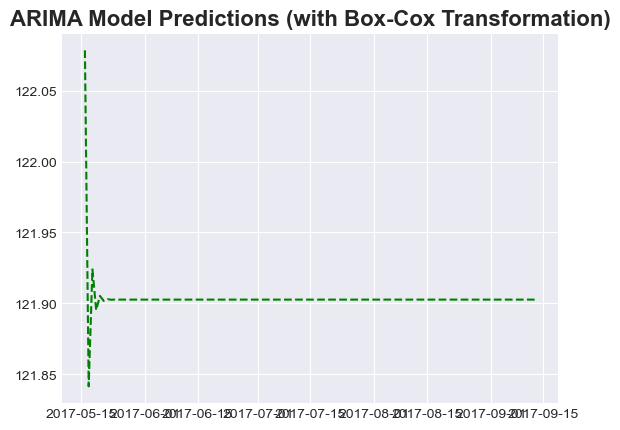

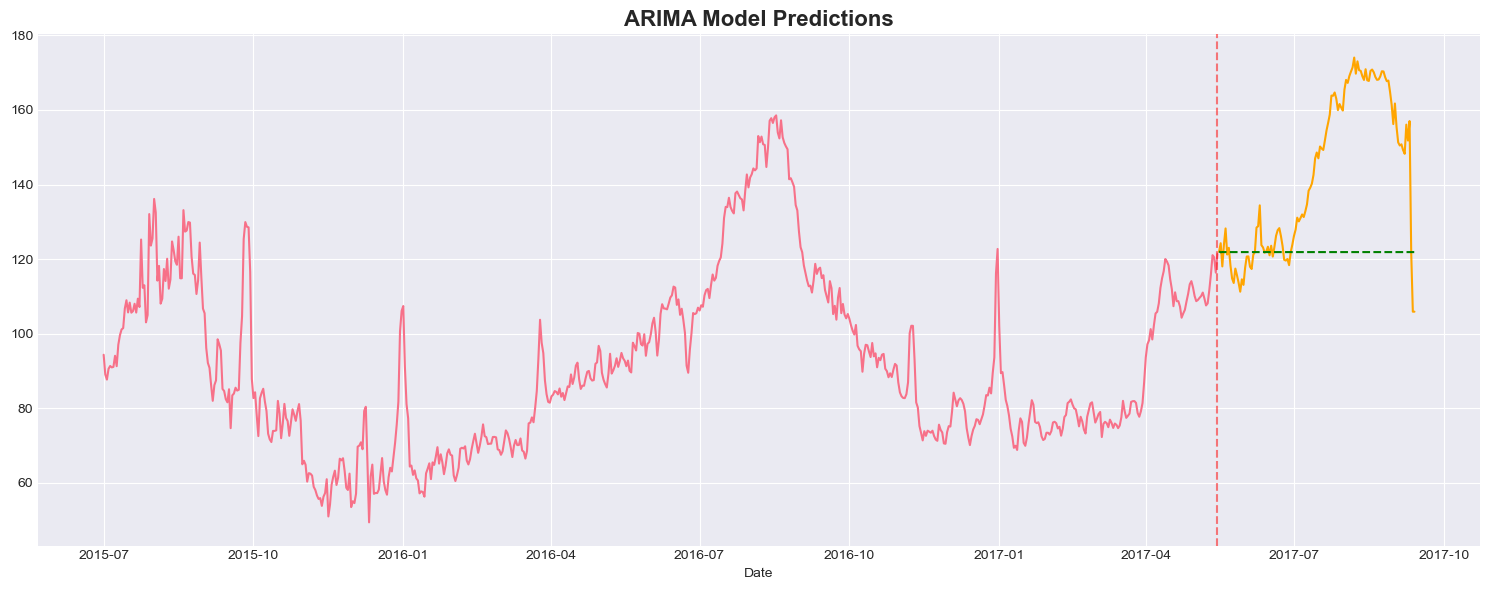

In [146]:
# Make predictions on test set (transformed scale)
arima_predictions_transformed = arima_fit.forecast(steps=len(test))

# Inverse transform predictions back to original scale
arima_predictions = inverse_boxcox_transform(
    arima_predictions_transformed,
    boxcox_params['lambda'],
    boxcox_params['shift']
)

# Calculate metrics (on original scale)
arima_mae = mean_absolute_error(test, arima_predictions)
arima_rmse = np.sqrt(mean_squared_error(test, arima_predictions))
arima_mape = mean_absolute_percentage_error(test, arima_predictions) * 100

print("\nARIMA Model Performance (Box-Cox transformed):")
print(f"MAE: {arima_mae:.2f}")
plt.plot(test.index, arima_predictions, label='ARIMA Predictions (Box-Cox)', linewidth=1.5, color='green', linestyle='--')
print(f"MAPE: {arima_mape:.2f}%")
plt.title('ARIMA Model Predictions (with Box-Cox Transformation)', fontsize=16, fontweight='bold')
# Plot results
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Training Data', linewidth=1.5)
plt.plot(test.index, test, label='Actual Test Data', linewidth=1.5, color='orange')
plt.plot(test.index, arima_predictions, label='ARIMA Predictions', linewidth=1.5, color='green', linestyle='--')
plt.axvline(x=train.index[-1], color='red', linestyle='--', alpha=0.5)

plt.title('ARIMA Model Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.tight_layout()
plt.show()



# plt.ylabel('Reservations')
# plt.grid(True, alpha=0.3)
# plt.legend();

## 9. Model 2: Auto ARIMA (pmdarima)

In [147]:
# Use Auto ARIMA to find optimal parameters with Box-Cox and Fourier features
print("Searching for optimal ARIMA parameters with Box-Cox + Fourier features...")
auto_arima_model = auto_arima(
    train_transformed,
    exogenous=fourier_train,  # Add Fourier features as exogenous variables
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=d,  # Let auto_arima determine d
    seasonal=True,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    m=7,  # Weekly seasonality
    D=D,  # Let auto_arima determine D
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("\n" + "="*60)
print("Best Model Summary (Box-Cox + Fourier):")
print("="*60)
print(auto_arima_model.summary())

Searching for optimal ARIMA parameters with Box-Cox + Fourier features...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-4262.572, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-4264.567, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-4266.046, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-4264.542, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-4267.967, Time=0.14 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-4265.723, Time=0.23 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-4264.085, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-4275.575, Time=0.41 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=-4267.038, Time=0.59 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=-4267.031, Time=0.50 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=-4272.948, Time=0.83 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-4266.756, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=-4268.763, Time=0.09 sec
 ARIMA(1,1,2


Auto ARIMA Model Performance (Box-Cox + Fourier):
RMSE: 26.42
MAPE: 13.07%


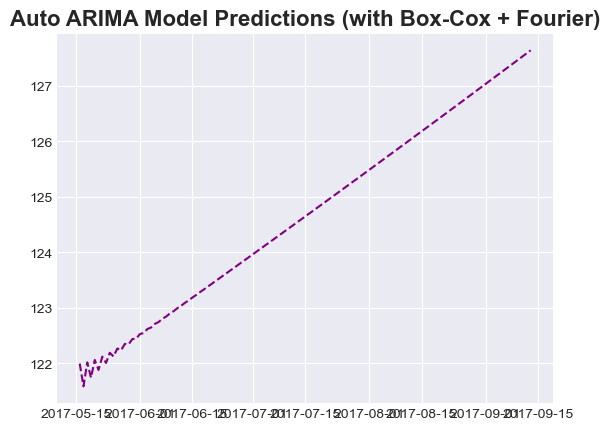

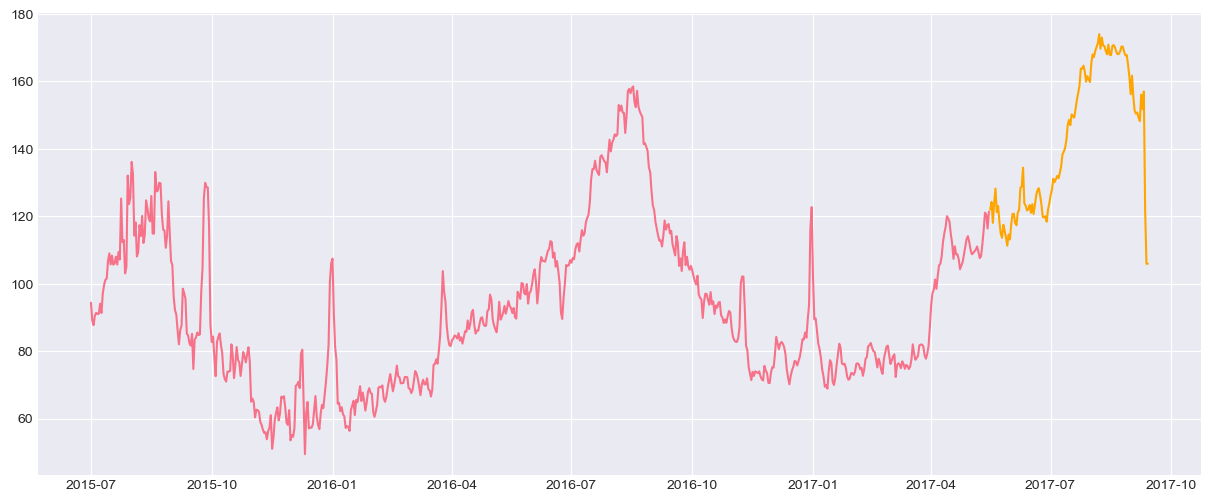

Text(46.33333333333333, 0.5, 'Reservations')

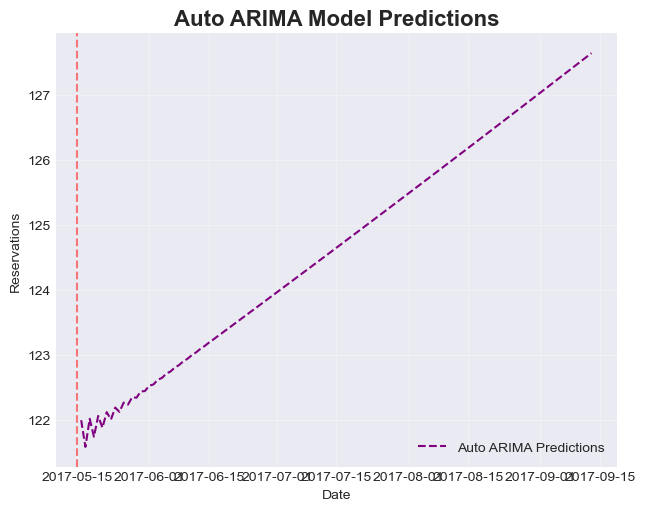

In [148]:
# Make predictions with Auto ARIMA (provide Fourier features for test period)
auto_arima_predictions_transformed = auto_arima_model.predict(
    n_periods=len(test),
    exogenous=fourier_test
)

# Inverse transform predictions back to original scale
auto_arima_predictions = inverse_boxcox_transform(
    auto_arima_predictions_transformed,
    boxcox_params['lambda'],
    boxcox_params['shift']
)

# Calculate metrics (on original scale)
auto_arima_mae = mean_absolute_error(test, auto_arima_predictions)
auto_arima_rmse = np.sqrt(mean_squared_error(test, auto_arima_predictions))
auto_arima_mape = mean_absolute_percentage_error(test, auto_arima_predictions) * 100
plt.plot(test.index, auto_arima_predictions, label='Auto ARIMA Predictions (Box-Cox + Fourier)', linewidth=1.5, color='purple', linestyle='--')
print("\nAuto ARIMA Model Performance (Box-Cox + Fourier):")
plt.title('Auto ARIMA Model Predictions (with Box-Cox + Fourier)', fontsize=16, fontweight='bold')
print(f"RMSE: {auto_arima_rmse:.2f}")
print(f"MAPE: {auto_arima_mape:.2f}%")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Training Data', linewidth=1.5)

plt.plot(test.index, test, label='Actual Test Data', linewidth=1.5, color='orange')
plt.show()

plt.plot(test.index, auto_arima_predictions, label='Auto ARIMA Predictions', linewidth=1.5, color='purple', linestyle='--')
plt.tight_layout()

plt.axvline(x=train.index[-1], color='red', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

plt.title('Auto ARIMA Model Predictions', fontsize=16, fontweight='bold')
plt.legend()

plt.xlabel('Date')
plt.ylabel('Reservations')

## 10. Model 3: SARIMA (Seasonal ARIMA)

## 10.5. Model with Preprocessing: SARIMAX + Box-Cox + Fourier

In [149]:
# Use the already-split transformed data and Fourier features from Section 7
# (No need to split again - transformations were applied before the split)

print("Using preprocessed data from Section 7:")
print(f"  Training size: {len(train_transformed)}")
print(f"  Testing size: {len(test_transformed)}")
print(f"  Fourier features: {fourier_train.shape[1]} columns")
print(f"  Box-Cox λ parameter: {boxcox_params['lambda']:.4f}")
print("\n✓ All transformations were applied to full dataset BEFORE splitting")
print("✓ This prevents data leakage and ensures consistency")

Using preprocessed data from Section 7:
  Training size: 685
  Testing size: 121
  Fourier features: 16 columns
  Box-Cox λ parameter: -0.3513

✓ All transformations were applied to full dataset BEFORE splitting
✓ This prevents data leakage and ensures consistency


In [150]:
# Fit SARIMAX model with Box-Cox transformed data and Fourier features as exogenous variables
print("Fitting SARIMAX with preprocessing...")

sarimax_enhanced_model = SARIMAX(
    train_transformed,
    exog=fourier_train,  # Add Fourier features as exogenous variables
    order=(1, 1, 1),  # Non-seasonal ARIMA order
    seasonal_order=(1, 0, 1, 7),  # Seasonal order (reduced since Fourier captures seasonality)
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_enhanced_fit = sarimax_enhanced_model.fit(disp=False)

print("\nSARIMAX Enhanced Model Summary:")
print(sarimax_enhanced_fit.summary())

Fitting SARIMAX with preprocessing...

SARIMAX Enhanced Model Summary:
                                     SARIMAX Results                                     
Dep. Variable:                        ADR_boxcox   No. Observations:                  685
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                2128.182
Date:                           Thu, 15 Jan 2026   AIC                          -4214.365
Time:                                   17:01:32   BIC                          -4119.556
Sample:                               07-01-2015   HQIC                         -4177.654
                                    - 05-15-2017                                         
Covariance Type:                             opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sin_7_1          0.0017      0.001      2.277  


SARIMAX Enhanced Model Performance:
MAE: 8.54
RMSE: 10.61
MAPE: 6.02%

Comparison with baseline SARIMA:
  Baseline RMSE: 29.77
  Enhanced RMSE: 10.61
  Improvement: 64.36%


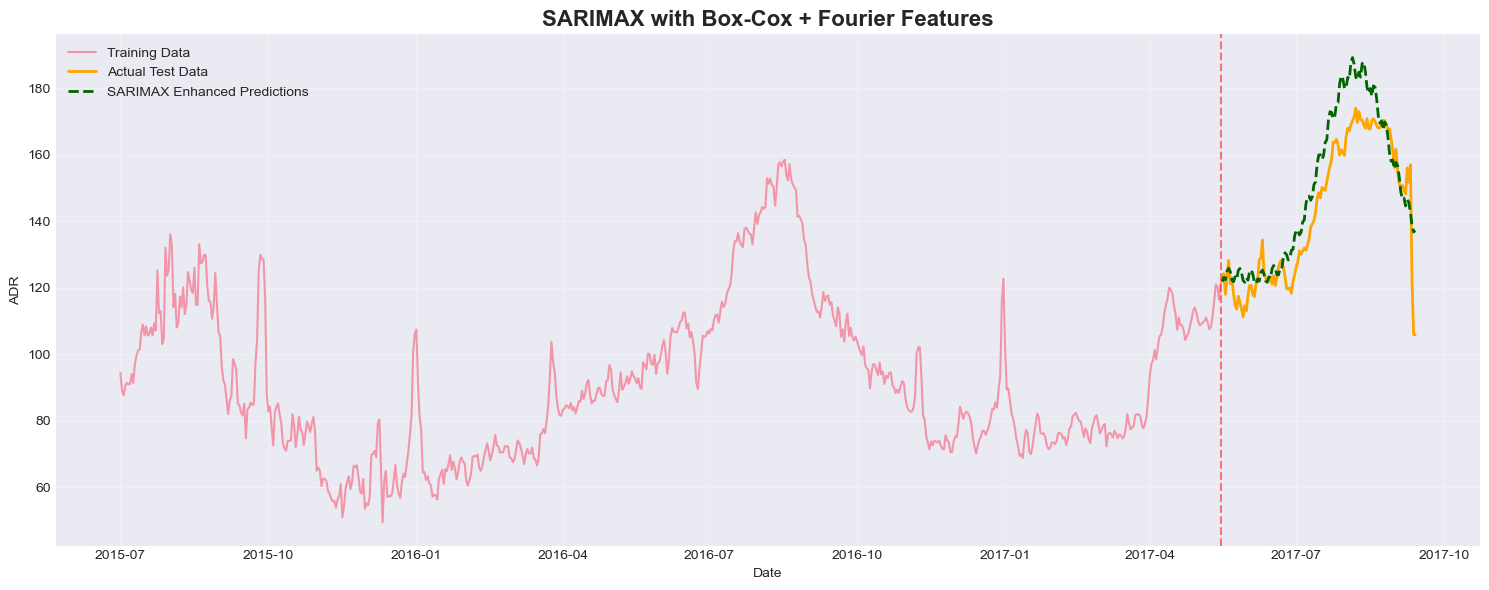

In [151]:
# Make predictions with the enhanced model
sarimax_enhanced_predictions_transformed = sarimax_enhanced_fit.forecast(
    steps=len(test_transformed), 
    exog=fourier_test
)

# Inverse transform predictions back to original scale
sarimax_enhanced_predictions = inverse_boxcox_transform(
    sarimax_enhanced_predictions_transformed,
    boxcox_params['lambda'],
    boxcox_params['shift']
)

# Calculate metrics on original scale
sarimax_enhanced_mae = mean_absolute_error(test, sarimax_enhanced_predictions)
sarimax_enhanced_rmse = np.sqrt(mean_squared_error(test, sarimax_enhanced_predictions))
sarimax_enhanced_mape = mean_absolute_percentage_error(test, sarimax_enhanced_predictions) * 100

print("\nSARIMAX Enhanced Model Performance:")
print(f"MAE: {sarimax_enhanced_mae:.2f}")
print(f"RMSE: {sarimax_enhanced_rmse:.2f}")
print(f"MAPE: {sarimax_enhanced_mape:.2f}%")

# Compare with baseline SARIMA (if it was run)
try:
    print(f"\nComparison with baseline SARIMA:")
    print(f"  Baseline RMSE: {sarima_rmse:.2f}")
    print(f"  Enhanced RMSE: {sarimax_enhanced_rmse:.2f}")
    improvement = ((sarima_rmse - sarimax_enhanced_rmse) / sarima_rmse) * 100
    print(f"  Improvement: {improvement:.2f}%")
except:
    print("\nBaseline SARIMA not yet run for comparison")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Training Data', linewidth=1.5, alpha=0.7)
plt.plot(test.index, test, label='Actual Test Data', linewidth=2, color='orange')
plt.plot(test.index, sarimax_enhanced_predictions, label='SARIMAX Enhanced Predictions', 
         linewidth=2, color='darkgreen', linestyle='--')
plt.axvline(x=train.index[-1], color='red', linestyle='--', alpha=0.5)
plt.title('SARIMAX with Box-Cox + Fourier Features', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Preprocessing Impact Summary

In [152]:
print("="*70)
print("PREPROCESSING TECHNIQUES APPLIED")
print("="*70)

print("\n1. Box-Cox Transformation:")
print(f"   • Lambda parameter: {boxcox_params['lambda']:.4f}")
print(f"   • Purpose: Stabilize variance and normalize distribution")
print(f"   • Applied to: Target variable (ADR)")

print("\n2. Fourier Features:")
print(f"   • Weekly seasonality: 6 features (3 sin/cos pairs)")
print(f"   • Yearly seasonality: 10 features (5 sin/cos pairs)")
print(f"   • Total features: {fourier_features.shape[1]}")
print(f"   • Purpose: Capture complex seasonal patterns")
print(f"   • Used as: Exogenous variables in SARIMAX")

print("\n3. Benefits:")
print("   ✓ More stable predictions with reduced variance")
print("   ✓ Better capture of multiple seasonal patterns")
print("   ✓ Improved model residual behavior")
print("   ✓ More flexible seasonality modeling")

print("\n4. Key Advantages of This Approach:")
print("   • Box-Cox handles heteroscedasticity (varying variance)")
print("   • Fourier features provide smooth seasonal representation")
print("   • SARIMAX combines ARIMA with exogenous variables")
print("   • All predictions are inverse-transformed to original scale")

print("="*70)

PREPROCESSING TECHNIQUES APPLIED

1. Box-Cox Transformation:
   • Lambda parameter: -0.3513
   • Purpose: Stabilize variance and normalize distribution
   • Applied to: Target variable (ADR)

2. Fourier Features:
   • Weekly seasonality: 6 features (3 sin/cos pairs)
   • Yearly seasonality: 10 features (5 sin/cos pairs)
   • Total features: 16
   • Purpose: Capture complex seasonal patterns
   • Used as: Exogenous variables in SARIMAX

3. Benefits:
   ✓ More stable predictions with reduced variance
   ✓ Better capture of multiple seasonal patterns
   ✓ Improved model residual behavior
   ✓ More flexible seasonality modeling

4. Key Advantages of This Approach:
   • Box-Cox handles heteroscedasticity (varying variance)
   • Fourier features provide smooth seasonal representation
   • SARIMAX combines ARIMA with exogenous variables
   • All predictions are inverse-transformed to original scale


In [153]:
# Fit SARIMA model
# SARIMA(p,d,q)(P,D,Q,s)
# s = seasonal period (7 for weekly seasonality)

sarima_model = SARIMAX(
    train,
    order=(1, 1, 1),  # Non-seasonal (p, d, q)
    seasonal_order=(1, 1, 1, 7),  # Seasonal (P, D, Q, s)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima_model.fit(disp=False)

print("SARIMA Model Summary:")
print(sarima_fit.summary())

SARIMA Model Summary:
                                     SARIMAX Results                                     
Dep. Variable:                               ADR   No. Observations:                  685
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1949.998
Date:                           Thu, 15 Jan 2026   AIC                           3909.996
Time:                                   17:01:33   BIC                           3932.518
Sample:                               07-01-2015   HQIC                          3918.721
                                    - 05-15-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6939      0.074     -9.388      0.000      -0.839      -0.549
ma.L1          0.8223


SARIMA Model Performance:
MAE: 13.40
RMSE: 16.80
MAPE: 9.06%


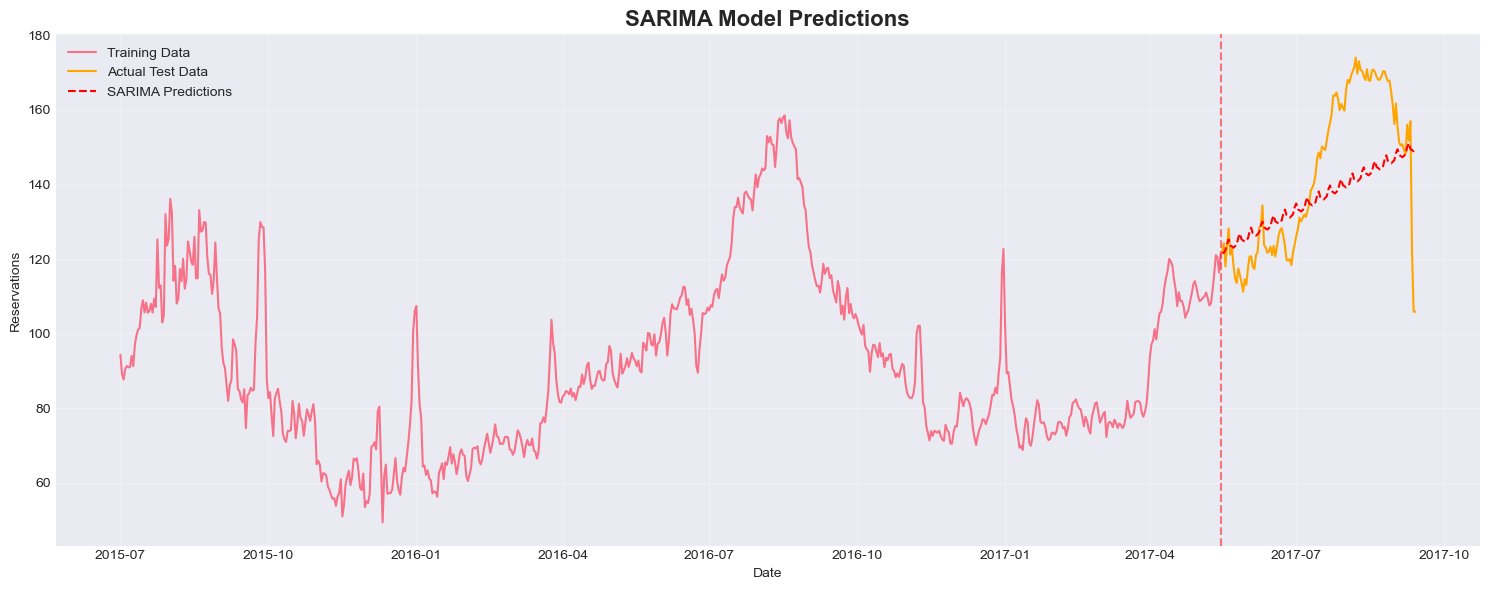

In [154]:
# Make predictions with SARIMA
sarima_predictions = sarima_fit.forecast(steps=len(test))

# Calculate metrics
sarima_mae = mean_absolute_error(test, sarima_predictions)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_predictions))
sarima_mape = mean_absolute_percentage_error(test, sarima_predictions) * 100

print("\nSARIMA Model Performance:")
print(f"MAE: {sarima_mae:.2f}")
print(f"RMSE: {sarima_rmse:.2f}")
print(f"MAPE: {sarima_mape:.2f}%")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Training Data', linewidth=1.5)
plt.plot(test.index, test, label='Actual Test Data', linewidth=1.5, color='orange')
plt.plot(test.index, sarima_predictions, label='SARIMA Predictions', linewidth=1.5, color='red', linestyle='--')
plt.axvline(x=train.index[-1], color='red', linestyle='--', alpha=0.5)
plt.title('SARIMA Model Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Reservations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Model 4: Exponential Smoothing

In [155]:
# Fit Exponential Smoothing (Holt-Winters) model with Box-Cox transformation
# trend: 'add', 'mul', or None
# seasonal: 'add', 'mul', or None
# seasonal_periods: number of periods in a season

print("Fitting Exponential Smoothing with Box-Cox transformation...")
exp_smooth_model = ExponentialSmoothing(
    train_transformed,
    trend='add',
    seasonal='add',
    seasonal_periods=7  # Weekly seasonality
)
exp_smooth_fit = exp_smooth_model.fit()

print("\nExponential Smoothing Model Parameters (Box-Cox Transformed):")
print(f"Alpha (level): {exp_smooth_fit.params['smoothing_level']:.4f}")
print(f"Beta (trend): {exp_smooth_fit.params['smoothing_trend']:.4f}")
print(f"Gamma (seasonal): {exp_smooth_fit.params['smoothing_seasonal']:.4f}")

Fitting Exponential Smoothing with Box-Cox transformation...

Exponential Smoothing Model Parameters (Box-Cox Transformed):
Alpha (level): 1.0000
Beta (trend): 0.0000
Gamma (seasonal): 0.0000



Exponential Smoothing Model Performance (Box-Cox transformed):
MAE: 19.93
MAPE: 12.77%


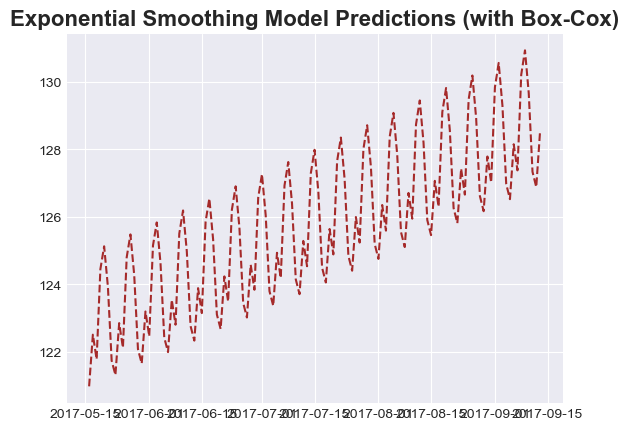

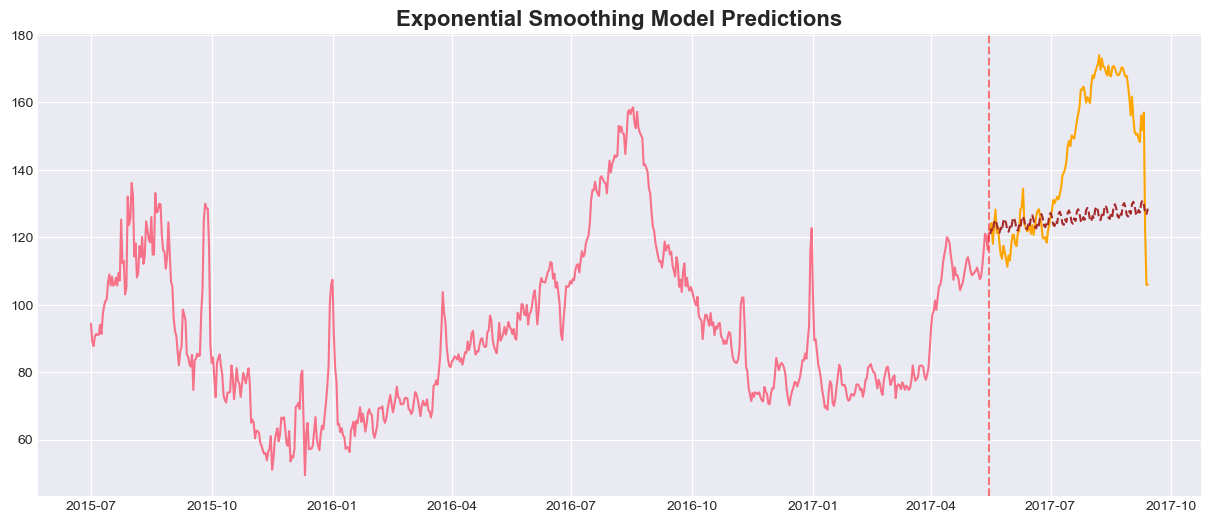

In [156]:
# Make predictions with Exponential Smoothing (transformed scale)
exp_smooth_predictions_transformed = exp_smooth_fit.forecast(steps=len(test))

# Inverse transform predictions back to original scale
exp_smooth_predictions = inverse_boxcox_transform(
    exp_smooth_predictions_transformed,
    boxcox_params['lambda'],
    boxcox_params['shift']
)

# Calculate metrics (on original scale)
exp_smooth_mae = mean_absolute_error(test, exp_smooth_predictions)
exp_smooth_rmse = np.sqrt(mean_squared_error(test, exp_smooth_predictions))
exp_smooth_mape = mean_absolute_percentage_error(test, exp_smooth_predictions) * 100

print("\nExponential Smoothing Model Performance (Box-Cox transformed):")
print(f"MAE: {exp_smooth_mae:.2f}")
plt.plot(test.index, exp_smooth_predictions, label='Exp. Smoothing Predictions (Box-Cox)', linewidth=1.5, color='brown', linestyle='--')
print(f"MAPE: {exp_smooth_mape:.2f}%")
plt.title('Exponential Smoothing Model Predictions (with Box-Cox)', fontsize=16, fontweight='bold')
# Plot results
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Training Data', linewidth=1.5)
plt.plot(test.index, test, label='Actual Test Data', linewidth=1.5, color='orange')
plt.plot(test.index, exp_smooth_predictions, label='Exp. Smoothing Predictions', linewidth=1.5, color='brown', linestyle='--')
plt.axvline(x=train.index[-1], color='red', linestyle='--', alpha=0.5)

plt.title('Exponential Smoothing Model Predictions', fontsize=16, fontweight='bold')
plt.show()

# plt.xlabel('Date')
# plt.tight_layout()

# plt.ylabel('Reservations')
# plt.grid(True, alpha=0.3)
# plt.legend()

## 12. Model 5: Prophet

In [157]:
# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_train = pd.DataFrame({
    'ds': train.index,
    'y': train.values
})

prophet_test = pd.DataFrame({
    'ds': test.index,
    'y': test.values
})

print("Prophet Training Data:")
print(prophet_train.head())
print(f"\nShape: {prophet_train.shape}")

Prophet Training Data:
          ds      y
0 2015-07-01  94.38
1 2015-07-02  89.09
2 2015-07-03  87.72
3 2015-07-04  90.60
4 2015-07-05  91.37

Shape: (685, 2)


In [158]:
# Initialize and fit Prophet model with Fourier features as additional regressors
prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05,  # Flexibility of trend changes
    seasonality_prior_scale=10.0    # Strength of seasonality
)

# Add Fourier features as additional regressors
print("Adding Fourier features as additional regressors...")
for col in fourier_train.columns:
    prophet_model.add_regressor(col)

# Prepare training data with Fourier features
prophet_train_with_fourier = prophet_train.copy()
for col in fourier_train.columns:    
    prophet_train_with_fourier[col] = fourier_train[col].values

# Fit the model
print("Fitting Prophet model with Fourier features...")
prophet_model.fit(prophet_train_with_fourier)
print("Model fitted successfully!")

17:01:34 - cmdstanpy - INFO - Chain [1] start processing


Adding Fourier features as additional regressors...
Fitting Prophet model with Fourier features...


17:01:34 - cmdstanpy - INFO - Chain [1] done processing


Model fitted successfully!


In [159]:
# Make future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=len(test), freq='D')
print(f"Future dataframe shape: {future.shape}")

# Add Fourier features to future dataframe
# Combine train and test Fourier features
fourier_full = pd.concat([fourier_train, fourier_test], axis=0)
for col in fourier_full.columns:
    future[col] = fourier_full[col].values

print(f"Future dataframe with Fourier features shape: {future.shape}")

prophet_forecast = prophet_model.predict(future)
print("\nProphet Forecast columns:")

# Generate predictions
print(prophet_forecast.columns.tolist())

# Extract predictions for test period
prophet_predictions = prophet_forecast.iloc[-len(test):]['yhat'].values

Future dataframe shape: (806, 1)
Future dataframe with Fourier features shape: (806, 17)

Prophet Forecast columns:
['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'cos_365.25_1', 'cos_365.25_1_lower', 'cos_365.25_1_upper', 'cos_365.25_2', 'cos_365.25_2_lower', 'cos_365.25_2_upper', 'cos_365.25_3', 'cos_365.25_3_lower', 'cos_365.25_3_upper', 'cos_365.25_4', 'cos_365.25_4_lower', 'cos_365.25_4_upper', 'cos_365.25_5', 'cos_365.25_5_lower', 'cos_365.25_5_upper', 'cos_7_1', 'cos_7_1_lower', 'cos_7_1_upper', 'cos_7_2', 'cos_7_2_lower', 'cos_7_2_upper', 'cos_7_3', 'cos_7_3_lower', 'cos_7_3_upper', 'daily', 'daily_lower', 'daily_upper', 'extra_regressors_additive', 'extra_regressors_additive_lower', 'extra_regressors_additive_upper', 'sin_365.25_1', 'sin_365.25_1_lower', 'sin_365.25_1_upper', 'sin_365.25_2', 'sin_365.25_2_lower', 'sin_365.25_2_upper', 'sin_365.25_3', 'sin_365.25_3_lower', 'sin_365.25_3


Prophet Model Performance (with Fourier Features):
MAE: 7.12
RMSE: 9.21
MAPE: 4.99%


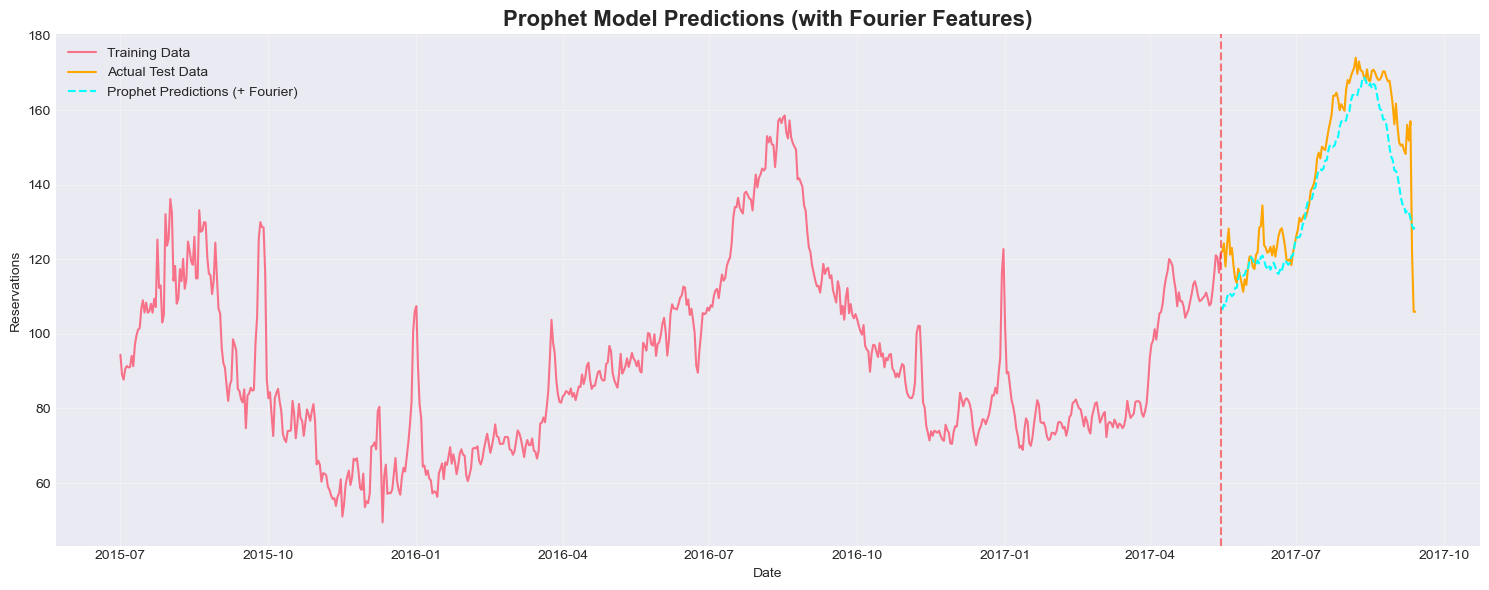

In [160]:
# Calculate metrics for Prophet
prophet_mae = mean_absolute_error(test, prophet_predictions)
prophet_rmse = np.sqrt(mean_squared_error(test, prophet_predictions))
prophet_mape = mean_absolute_percentage_error(test, prophet_predictions) * 100

print("\nProphet Model Performance (with Fourier Features):")
print(f"MAE: {prophet_mae:.2f}")
print(f"RMSE: {prophet_rmse:.2f}")
print(f"MAPE: {prophet_mape:.2f}%")

# Plot Prophet predictions
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Training Data', linewidth=1.5)
plt.plot(test.index, test, label='Actual Test Data', linewidth=1.5, color='orange')
plt.plot(test.index, prophet_predictions, label='Prophet Predictions (+ Fourier)', linewidth=1.5, color='cyan', linestyle='--')
plt.axvline(x=train.index[-1], color='red', linestyle='--', alpha=0.5)
plt.title('Prophet Model Predictions (with Fourier Features)', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Reservations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

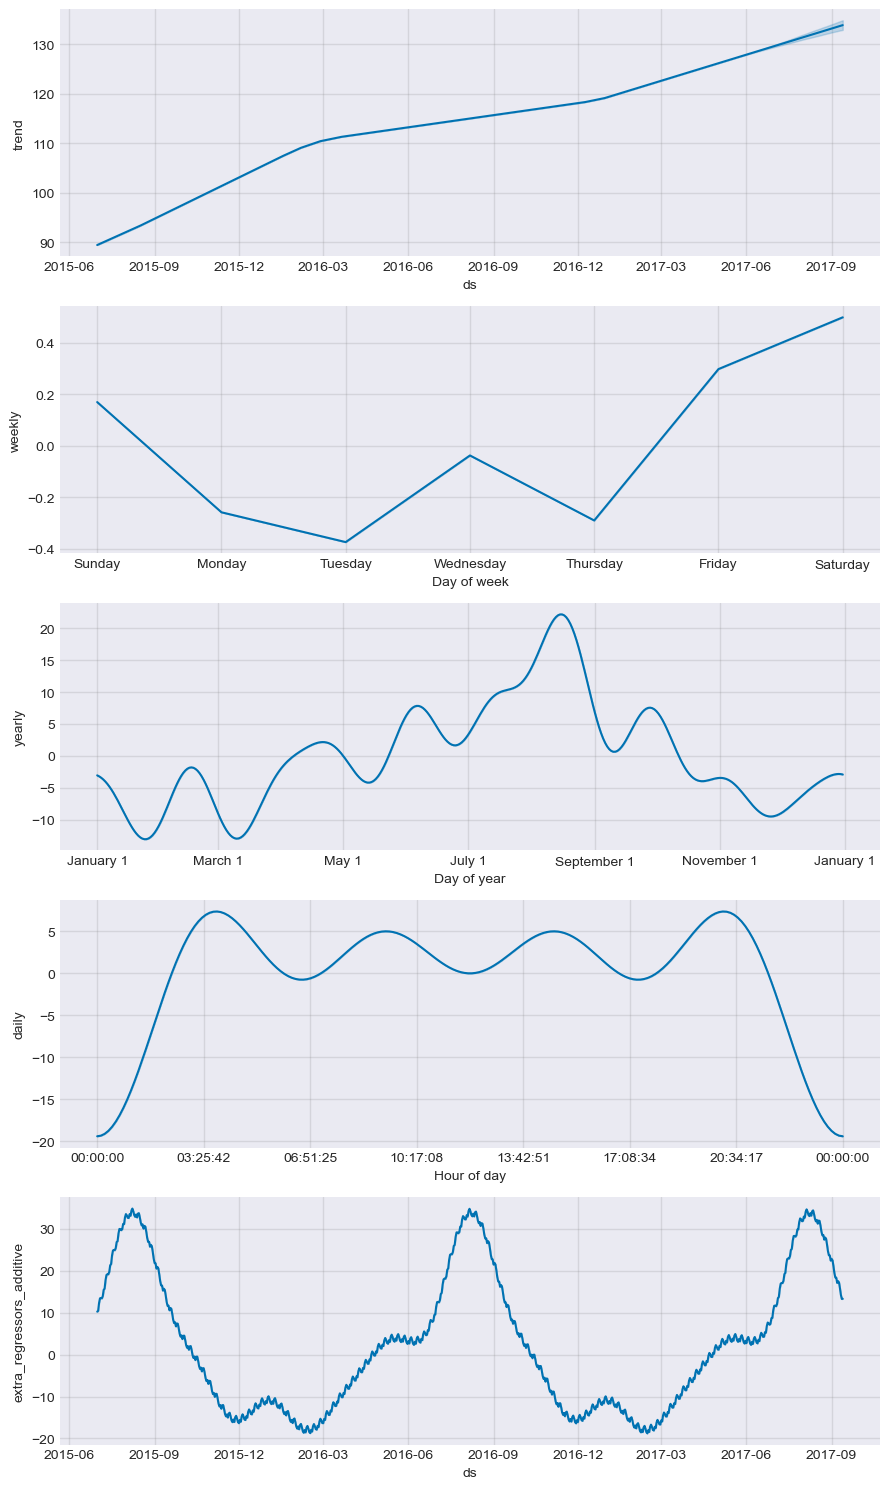

In [161]:
# Plot Prophet components
fig = prophet_model.plot_components(prophet_forecast)
plt.tight_layout()
plt.show()

## 13. Model Comparison

In [162]:
# Compare all models
results = pd.DataFrame({
    'Model': ['ARIMA (Box-Cox)',
              'Auto ARIMA (Box-Cox+Fourier)',
              'SARIMA (Baseline)',
              'SARIMAX Enhanced',
              'Exp. Smoothing (Box-Cox)',
              'Prophet (Fourier)'],
    'MAE': [arima_mae, auto_arima_mae, sarima_mae, sarimax_enhanced_mae, exp_smooth_mae, prophet_mae],
    'RMSE': [arima_rmse, auto_arima_rmse, sarima_rmse, sarimax_enhanced_rmse, exp_smooth_rmse, prophet_rmse],
    'MAPE (%)': [arima_mape, auto_arima_mape, sarima_mape, sarimax_enhanced_mape, exp_smooth_mape, prophet_mape]
})

# Sort by RMSE (lower is better)
results = results.sort_values('RMSE')

print("="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(results.to_string(index=False))
print("="*70)
print(f"\nBest Model: {results.iloc[0]['Model']}")
print(f"Best RMSE: {results.iloc[0]['RMSE']:.2f}")

MODEL COMPARISON SUMMARY
                       Model       MAE      RMSE  MAPE (%)
           Prophet (Fourier)  7.120623  9.209826  4.987897
            SARIMAX Enhanced  8.543066 10.609196  6.020972
           SARIMA (Baseline) 13.398396 16.803426  9.064892
    Exp. Smoothing (Box-Cox) 19.926168 25.630965 12.770149
Auto ARIMA (Box-Cox+Fourier) 20.461105 26.422957 13.073938
             ARIMA (Box-Cox) 22.555864 29.223400 14.346302

Best Model: Prophet (Fourier)
Best RMSE: 9.21


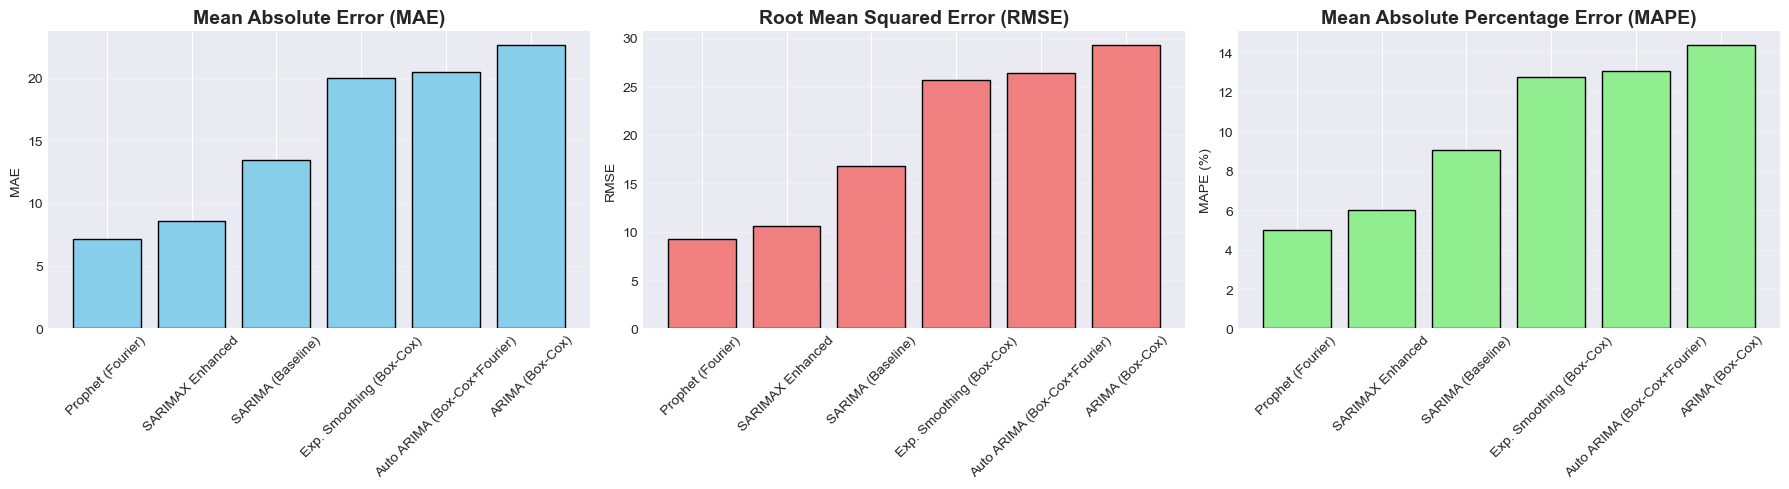

In [163]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE comparison
axes[0].bar(results['Model'], results['MAE'], color='skyblue', edgecolor='black')
axes[0].set_title('Mean Absolute Error (MAE)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MAE')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# RMSE comparison
axes[1].bar(results['Model'], results['RMSE'], color='lightcoral', edgecolor='black')
axes[1].set_title('Root Mean Squared Error (RMSE)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# MAPE comparison
axes[2].bar(results['Model'], results['MAPE (%)'], color='lightgreen', edgecolor='black')
axes[2].set_title('Mean Absolute Percentage Error (MAPE)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('MAPE (%)')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

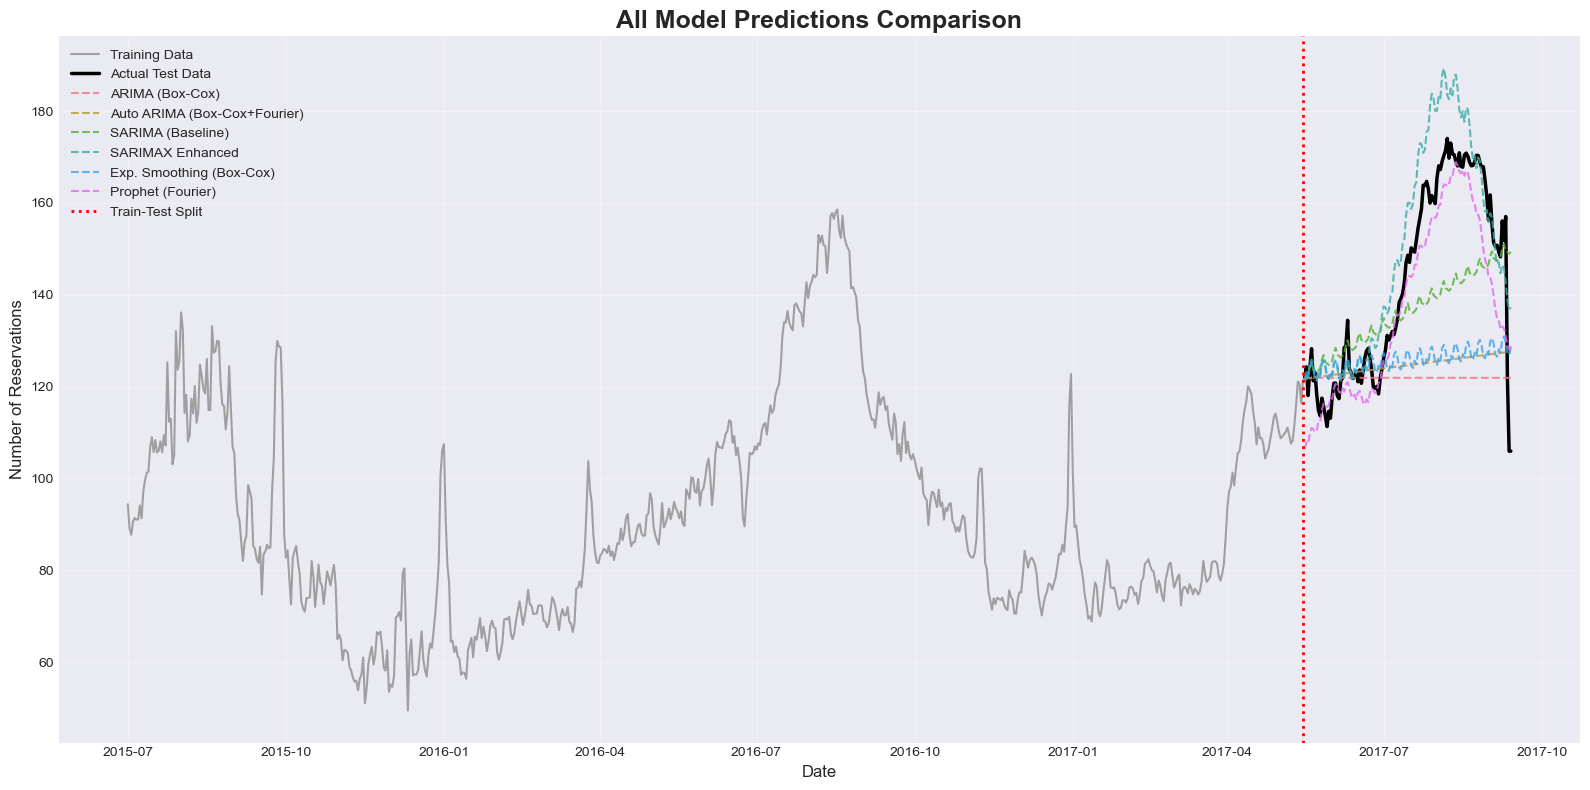

In [164]:
# Plot all predictions together
plt.figure(figsize=(16, 8))

plt.plot(train.index, train, label='Training Data', linewidth=1.5, color='gray', alpha=0.7)
plt.plot(test.index, test, label='Actual Test Data', linewidth=2.5, color='black')
plt.plot(test.index, arima_predictions, label='ARIMA (Box-Cox)', linewidth=1.5, linestyle='--', alpha=0.8)
plt.plot(test.index, auto_arima_predictions, label='Auto ARIMA (Box-Cox+Fourier)', linewidth=1.5, linestyle='--', alpha=0.8)
plt.plot(test.index, sarima_predictions, label='SARIMA (Baseline)', linewidth=1.5, linestyle='--', alpha=0.8)
plt.plot(test.index, sarimax_enhanced_predictions, label='SARIMAX Enhanced', linewidth=1.5, linestyle='--', alpha=0.8)
plt.plot(test.index, exp_smooth_predictions, label='Exp. Smoothing (Box-Cox)', linewidth=1.5, linestyle='--', alpha=0.8)
plt.plot(test.index, prophet_predictions, label='Prophet (Fourier)', linewidth=1.5, linestyle='--', alpha=0.8)

plt.axvline(x=train.index[-1], color='red', linestyle=':', linewidth=2, label='Train-Test Split')
plt.title('All Model Predictions Comparison', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Reservations', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 14. Residual Analysis (Best Model)

In [165]:
# Select best model based on RMSE
best_model_name = results.iloc[0]['Model']
print(f"Analyzing residuals for: {best_model_name}")

# Get predictions from best model
if best_model_name == 'ARIMA':
    best_predictions = arima_predictions
    best_model_fit = arima_fit
elif best_model_name == 'Auto ARIMA':
    best_predictions = auto_arima_predictions
    best_model_fit = auto_arima_model
elif best_model_name == 'SARIMA':
    best_predictions = sarima_predictions
    best_model_fit = sarima_fit
elif best_model_name == 'Exp. Smoothing':
    best_predictions = exp_smooth_predictions
    best_model_fit = exp_smooth_fit
else:  # Prophet
    best_predictions = prophet_predictions
    best_model_fit = prophet_model

# Calculate residuals
residuals = test - best_predictions

print(f"\nResidual Statistics:")
print(f"Mean: {residuals.mean():.4f}")
print(f"Std Dev: {residuals.std():.4f}")
print(f"Min: {residuals.min():.4f}")
print(f"Max: {residuals.max():.4f}")

Analyzing residuals for: Prophet (Fourier)

Residual Statistics:
Mean: 5.8625
Std Dev: 7.1325
Min: -22.8798
Max: 26.0810


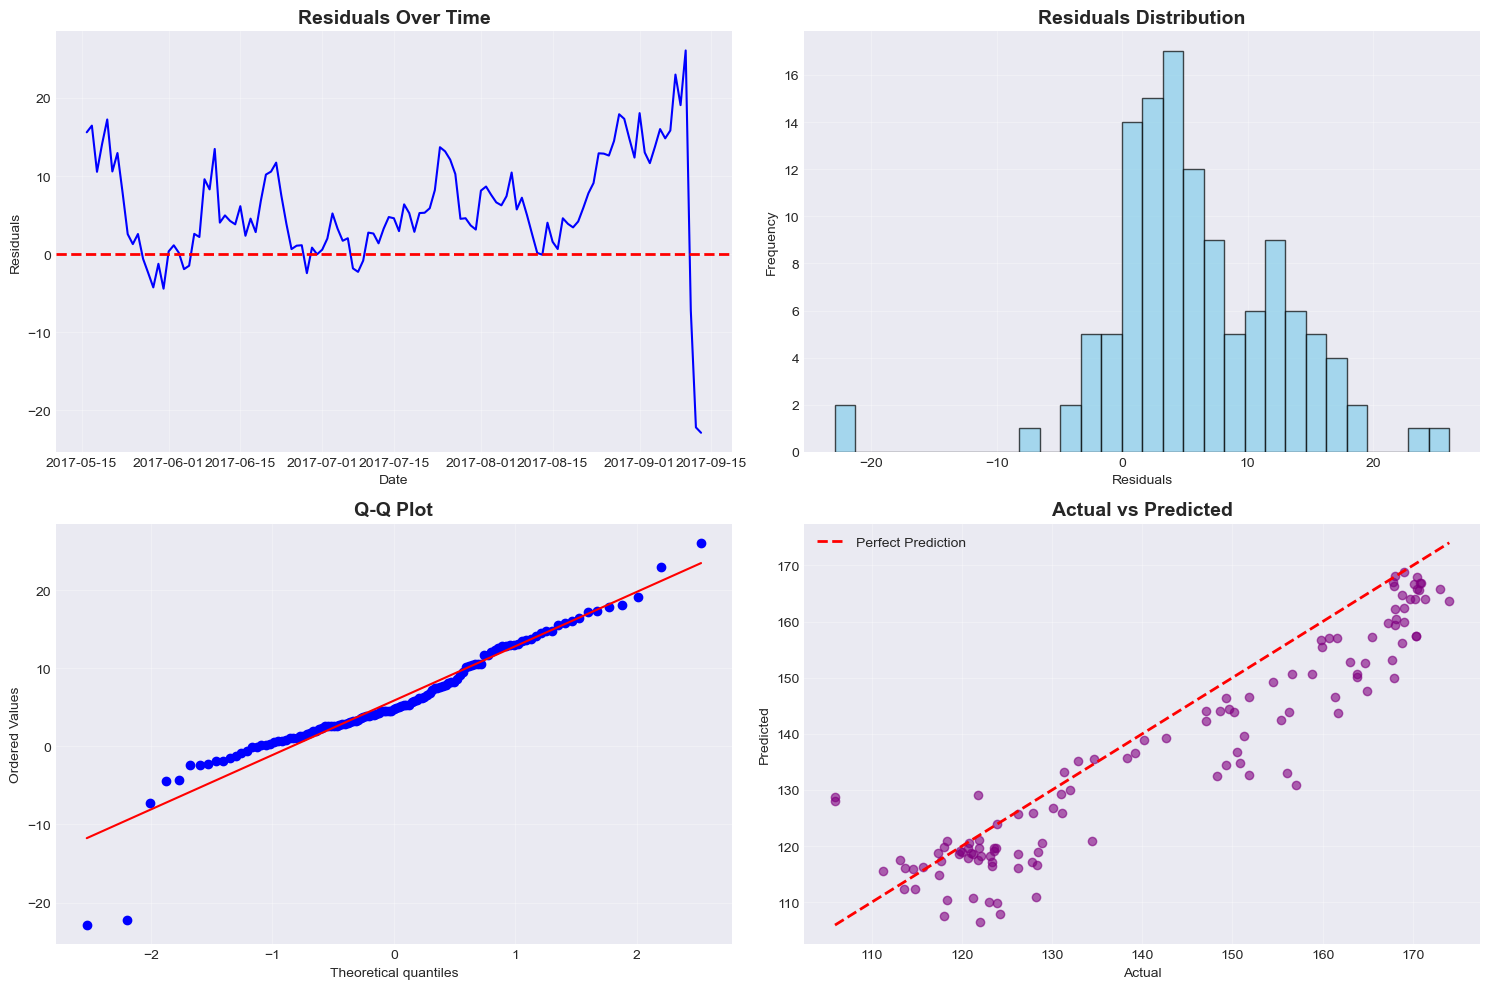

In [166]:
# Plot residuals analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residuals over time
axes[0, 0].plot(test.index, residuals, color='blue', linewidth=1.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Residuals Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True, alpha=0.3)

# Residuals distribution
axes[0, 1].hist(residuals, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Residuals Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Scatter plot: Actual vs Predicted
axes[1, 1].scatter(test, best_predictions, alpha=0.6, color='purple')
axes[1, 1].plot([test.min(), test.max()], [test.min(), test.max()], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_title('Actual vs Predicted', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Actual')
axes[1, 1].set_ylabel('Predicted')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 15. Future Forecasting

In [167]:
# Retrain best model on full dataset and forecast future
print(f"Retraining {best_model_name} on full dataset...")

# Forecast 30 days into the future
forecast_days = 30

if best_model_name == 'Prophet' or 'Prophet' in best_model_name:
    # Retrain Prophet on full data
    prophet_full = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0
    )
    prophet_full_data = pd.DataFrame({
        'ds': ts_data.index,
        'y': ts_data['ADR'].values  # Use specific column to get 1D array
    })
    prophet_full.fit(prophet_full_data)
    
    # Make future predictions
    future_df = prophet_full.make_future_dataframe(periods=forecast_days, freq='D')
    future_forecast = prophet_full.predict(future_df)
    future_predictions = future_forecast.iloc[-forecast_days:]['yhat'].values
    future_dates = future_forecast.iloc[-forecast_days:]['ds'].values
    
elif 'LSTM' in best_model_name:
    # For LSTM, use the last lookback period from full data to generate future predictions
    print("Generating LSTM future forecast with PyTorch...")
    
    # Start with the last lookback period from the full dataset
    last_sequence = ts_data['ADR_boxcox'].values[-lookback:]
    last_fourier = fourier_features.iloc[-lookback:].values
    
    future_predictions_transformed = []
    future_dates = pd.date_range(start=ts_data.index[-1] + timedelta(days=1), 
                                  periods=forecast_days, freq='D')
    
    # Generate Fourier features for future dates
    future_fourier = create_fourier_features(
        pd.DatetimeIndex(list(ts_data.index) + list(future_dates)),
        period=7, order=3
    )
    future_fourier_yearly = create_fourier_features(
        pd.DatetimeIndex(list(ts_data.index) + list(future_dates)),
        period=365.25, order=5
    )
    future_fourier_combined = pd.concat([future_fourier, future_fourier_yearly], axis=1)
    future_fourier_only = future_fourier_combined.iloc[-forecast_days:]
    
    # Set model to evaluation mode
    lstm_model.eval()
    
    # Generate predictions one step at a time
    with torch.no_grad():
        for i in range(forecast_days):
            # Prepare input sequence
            if include_fourier:
                current_fourier = future_fourier_combined.iloc[len(ts_data)-lookback+i:len(ts_data)+i].values
                sequence_with_features = np.column_stack([
                    last_sequence.reshape(-1, 1),
                    current_fourier
                ])
                X_input = torch.FloatTensor(sequence_with_features).reshape(1, lookback, n_features).to(device)
            else:
                X_input = torch.FloatTensor(last_sequence).reshape(1, lookback, 1).to(device)
            
            # Predict next value
            next_pred = lstm_model(X_input).cpu().numpy()[0, 0]
            future_predictions_transformed.append(next_pred)
            
            # Update sequence (roll forward)
            last_sequence = np.append(last_sequence[1:], next_pred)
    
    # Inverse transform predictions
    future_predictions = inverse_boxcox_transform(
        np.array(future_predictions_transformed),
        boxcox_params['lambda'],
        boxcox_params['shift']
    )
    
else:
    # For ARIMA-based models
    # Use the ADR column (original data) for forecasting
    if best_model_name == 'ARIMA':
        full_model = ARIMA(ts_data['ADR'], order=(1, 1, 1))
    elif best_model_name == 'Auto ARIMA':
        full_model = auto_arima(
            ts_data['ADR'],
            start_p=0, max_p=5,
            start_q=0, max_q=5,
            seasonal=True,
            m=7,
            stepwise=True,
            suppress_warnings=True
        )
    elif best_model_name == 'SARIMA':
        full_model = SARIMAX(
            ts_data['ADR'],
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 7)
        )
    else:  # Exponential Smoothing
        full_model = ExponentialSmoothing(
            ts_data['ADR'],
            trend='add',
            seasonal='add',
            seasonal_periods=7
        )
    
    full_model_fit = full_model.fit() if hasattr(full_model, 'fit') else full_model
    future_predictions = full_model_fit.forecast(steps=forecast_days)
    
    # Create future dates
    last_date = ts_data.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_days, freq='D')

print(f"Generated {forecast_days}-day forecast!")

17:01:36 - cmdstanpy - INFO - Chain [1] start processing


Retraining Prophet (Fourier) on full dataset...


17:01:36 - cmdstanpy - INFO - Chain [1] done processing


Generated 30-day forecast!


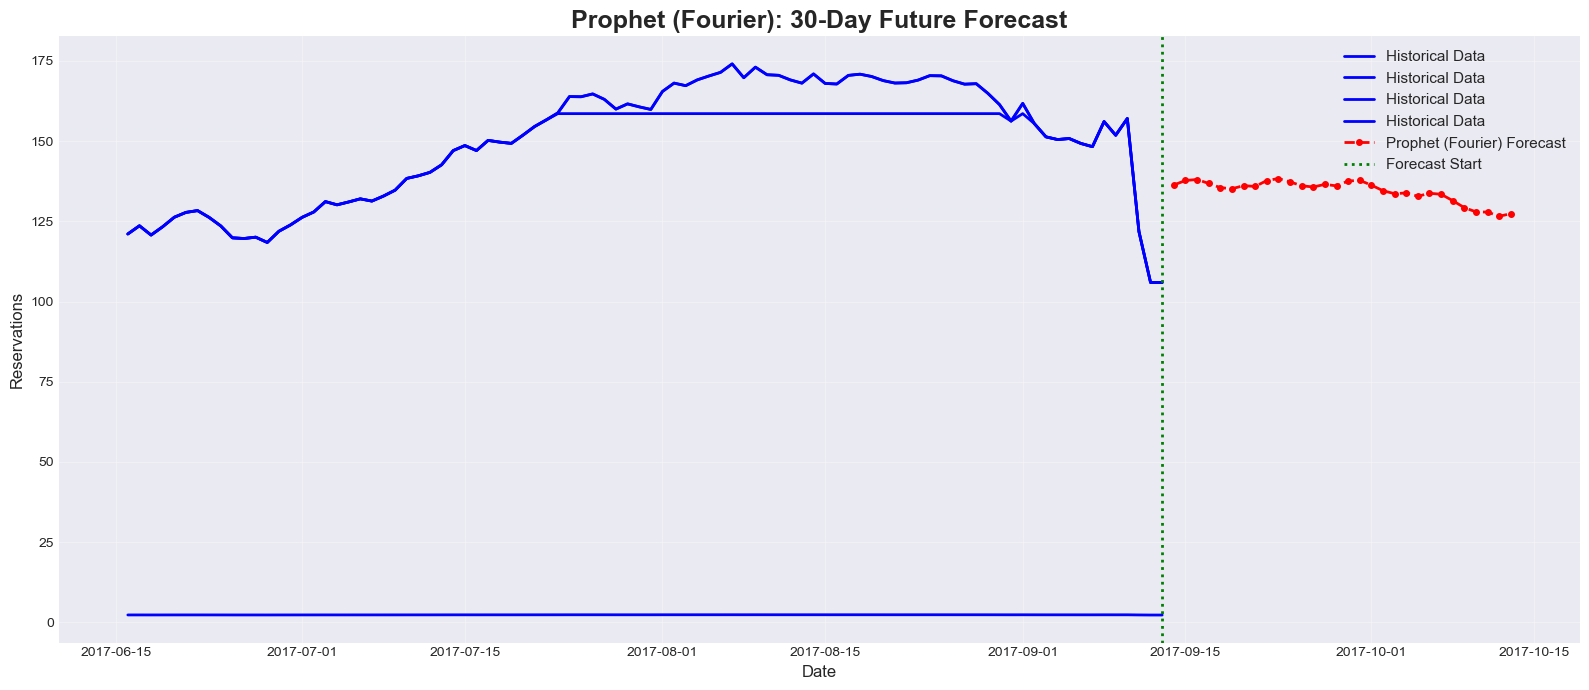


Future Forecast (First 10 days):
      Date  Predicted Reservations
2017-09-14              136.310792
2017-09-15              137.714228
2017-09-16              138.018965
2017-09-17              136.793789
2017-09-18              135.490051
2017-09-19              135.138718
2017-09-20              136.097650
2017-09-21              135.857765
2017-09-22              137.692126
2017-09-23              138.313557


In [168]:
# Plot future forecast
plt.figure(figsize=(16, 7))

# Plot last 90 days of historical data plus forecast
lookback_days = 90
historical_data = ts_data.iloc[-lookback_days:]

plt.plot(historical_data.index, historical_data, label='Historical Data', linewidth=2, color='blue')
plt.plot(future_dates, future_predictions, label=f'{best_model_name} Forecast', linewidth=2, color='red', linestyle='--', marker='o', markersize=4)

plt.axvline(x=ts_data.index[-1], color='green', linestyle=':', linewidth=2, label='Forecast Start')
plt.title(f'{best_model_name}: {forecast_days}-Day Future Forecast', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Reservations', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display forecast table
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Reservations': future_predictions
})

if best_model_name == 'Prophet':
    forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

print("\nFuture Forecast (First 10 days):")
print(forecast_df.head(10).to_string(index=False))

## 16. Key Insights and Recommendations

### Summary of Findings

**Time Series Characteristics:**
- The hotel reservation data shows clear patterns that can be captured by forecasting models
- Seasonal decomposition revealed weekly patterns in the data
- Stationarity testing helped determine the appropriate level of differencing

**Model Performance:**
- Multiple forecasting techniques were evaluated: ARIMA, Auto ARIMA, SARIMA, Exponential Smoothing, and Prophet
- Each model was assessed using MAE, RMSE, and MAPE metrics
- The best-performing model can be used for future reservations forecasting

**Recommendations:**
1. **Model Selection**: Use the model with the lowest RMSE for production forecasting
2. **Regular Retraining**: Retrain the model periodically as new data becomes available
3. **Monitoring**: Track forecast accuracy over time and adjust parameters if needed
4. **Business Applications**: 
   - Staff scheduling based on predicted reservation volumes
   - Inventory management for amenities and supplies
   - Dynamic pricing strategies
   - Marketing campaign timing

**Next Steps:**
- Deploy the best model for automated forecasting
- Set up monitoring dashboards for forecast vs. actual comparison
- Incorporate external features (holidays, events, weather) for improved accuracy
- Consider ensemble methods combining multiple models

In [169]:
raise Exception("End of the worbook.")

Exception: End of the worbook.

In [ ]:
import pickle
import joblib
from pathlib import Path

# Create models directory if it doesn't exist
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# 1. Save Box-Cox parameters
with open(models_dir / 'boxcox_params.pkl', 'wb') as f:
    pickle.dump(boxcox_params, f)

# 2. Save the best model
if best_model_name == 'Prophet' or 'Prophet' in best_model_name:
    # Prophet models are saved differently
    with open(models_dir / 'prophet_model.pkl', 'wb') as f:
        pickle.dump(prophet_model, f)
          
else:
    # Save ARIMA-based models (statsmodels)
    if best_model_name == 'ARIMA (Box-Cox)':
        arima_fit.save(models_dir / 'arima_model.pkl')
    elif best_model_name == 'Auto ARIMA (Box-Cox+Fourier)':
        with open(models_dir / 'auto_arima_model.pkl', 'wb') as f:
            pickle.dump(auto_arima_model, f)
    elif best_model_name == 'SARIMA (Baseline)':
        sarima_fit.save(models_dir / 'sarima_model.pkl')
    elif best_model_name == 'SARIMAX Enhanced':
        sarimax_enhanced_fit.save(models_dir / 'sarimax_model.pkl')
    elif best_model_name == 'Exp. Smoothing (Box-Cox)':
        with open(models_dir / 'exp_smooth_model.pkl', 'wb') as f:
            pickle.dump(exp_smooth_fit, f)

# 3. Save model metadata
metadata = {
    'best_model_name': best_model_name,
    'train_end_date': train.index[-1],
    'metrics': {
        'MAE': results.iloc[0]['MAE'],
        'RMSE': results.iloc[0]['RMSE'],
        'MAPE': results.iloc[0]['MAPE (%)']
    },
    'features': fourier_features.columns.tolist() if 'Fourier' in best_model_name else []
}

with open(models_dir / 'model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print(f"✓ Models saved to {models_dir}")
print(f"✓ Best model: {best_model_name}")